# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'

!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
# data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 14.6MB 48kB/s  eta 0:00:01
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

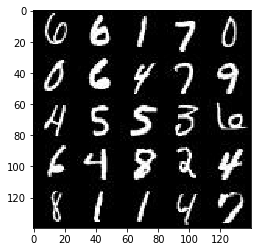

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

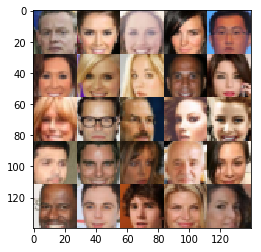

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) > LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real')
    z_tensor = tf.placeholder(tf.float32, shape=(None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, shape=(), name='learning_rate')
    return real_inputs, z_tensor, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.08
    with tf.variable_scope('discriminator', reuse=reuse):
        
        h1 = tf.layers.conv2d(images, 128, 5, strides=(2,2), padding="same", kernel_initializer=tf.contrib.layers.xavier_initializer())
        h1 = tf.nn.dropout(h1, keep_prob =0.8)
        h1 = tf.maximum(alpha * h1, h1)
        
        h2 = tf.layers.conv2d(h1, 256, 5, strides=(2,2), padding="same", kernel_initializer=tf.contrib.layers.xavier_initializer())
        h2 = tf.nn.dropout(h2, keep_prob =0.8)
        h2 = tf.layers.batch_normalization(h2, training=True)
        h2 = tf.maximum(alpha * h2, h2)
        
        h3 = tf.layers.conv2d(h2, 512, 5, strides=(2,2), padding="same", kernel_initializer=tf.contrib.layers.xavier_initializer())
        h3 = tf.nn.dropout(h3, keep_prob =0.8)
        h3 = tf.layers.batch_normalization(h3, training=True)
        h3 = tf.maximum(alpha * h3, h3)
        
        layer_flat = tf.reshape(h3, [-1, 4*4*512])
        tensor_logits = tf.layers.dense(layer_flat, 1, kernel_initializer=tf.contrib.layers.xavier_initializer())
        drop_added = tf.nn.dropout(tensor_logits, keep_prob =0.8)
        tensor_out = tf.sigmoid(drop_added)
        
        return tensor_out, tensor_logits

# SPECIFICATIONS CHANGES:
# After the first submission and reading the feedback, I experimented with few changes and added these to improve
#  my discriminator output. I added a custom weight initializer to ensure non-linearity and to improve overall
#  performance. A dropout layer with a probability of 0.8 was added to help with hyper learning distribution and to make
#  sure that the discriminator does not dominate the generator. The slope of leaky relu was also increased to 0.08. 

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.08
    with tf.variable_scope('generator', reuse=not(is_train)):
        
        h1 = tf.layers.dense(z, 7*7*1024, kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
        h1 = tf.reshape(h1, [-1, 7, 7, 512])
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha * h1, h1)
        h1 = tf.nn.dropout(h1, keep_prob =0.9)
        
        h2 = tf.layers.conv2d_transpose(h1, 256, 5, strides=(2,2), padding="same", kernel_initializer=tf.contrib.layers.xavier_initializer())
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha * h2, h2)
        h2 = tf.nn.dropout(h2, keep_prob =0.9)
        
        h3 = tf.layers.conv2d_transpose(h2, 128, 5, strides=(2,2), padding="same", kernel_initializer=tf.contrib.layers.xavier_initializer())
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha * h3, h3)
        h3 = tf.nn.dropout(h3, keep_prob =0.9)
        
        tensor_logits = tf.layers.conv2d_transpose(h3, out_channel_dim, 5, strides=(1,1), padding="same", kernel_initializer=tf.contrib.layers.xavier_initializer())
        drop_added = tf.nn.dropout(tensor_logits, keep_prob =0.9)
        tensor_out = tf.tanh(tensor_logits)
        
        return tensor_out

# SPECIFICATIONS CHANGES:
# After the first submission and reading the feedback, I experimented with few changes and added these to improve
#  my generator output. I added the suggested model size 1024>512>256>128, and made sure it has weight initializers
#  just like my discriminator. I also increased the leaky relu to be 0.08 (same as discriminator).

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
import numpy as np

def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    gen_model = generator(input_z, out_channel_dim, is_train=True)
    dis_real_model, dis_real_logit  = discriminator(input_real, reuse=False)
    dis_fake_model, dis_fake_logit  = discriminator(gen_model, reuse=True)
    
    dis_real_dist = np.random.uniform(low=1.0, high=1.2)
    dis_real_labels = tf.ones_like(dis_real_logit) * dis_real_dist
    dis_real_cross = tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_real_logit, labels=dis_real_labels)
    dis_real_loss = tf.reduce_mean(dis_real_cross)
    
    dis_fake_dist = np.random.uniform(low=0.1, high=0.4)
    dis_fake_labels = tf.ones_like(dis_fake_logit) * dis_fake_dist
    dis_fake_cross = tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_fake_logit, labels=dis_fake_labels)
    dis_fake_loss = tf.reduce_mean(dis_fake_cross)
    
    gen_labels = tf.ones_like(dis_fake_model)
    gen_cross = tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_fake_logit, labels=gen_labels) 
    
    gen_loss = tf.reduce_mean(gen_cross)  
    dis_total_loss = dis_real_loss + dis_fake_loss
    
    return dis_total_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    ten_v = tf.trainable_variables()
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    gen_v = [v for v in ten_v if v.name.startswith("generator")]
    dis_v = [v for v in ten_v if v.name.startswith("discriminator")]
    
    with tf.control_dependencies(update_ops):
        gen_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_v)
        dis_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=dis_v)
    
    return dis_opt, gen_opt

# SPECIFICATIONS CHANGES:
# After the first submission and reading the feedback, I added the control dependencies so that batch normalization
#  works properly during inference.

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
%matplotlib inline

def plot_losses(dis_loss_graph, gen_loss_graph):
    fig, ax = pyplot.subplots()
    pyplot.title("Training")
    pyplot.plot(dis_loss_graph, label='Discriminator', alpha=0.5)
    pyplot.plot(gen_loss_graph, label='Generator', alpha=0.5)
    pyplot.legend()

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    counter = 0
    show_n_images = 10
    dis_loss_graph, gen_loss_graph = [], []
    _,image_width,image_height,image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    dis_loss, gen_loss = model_loss(input_real, input_z, image_channels)
    dis_opt, gen_opt = model_opt(dis_loss, gen_loss, learning_rate, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                counter += 1
                batch_images *= 2
                batch_z_dim = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                sess.run(dis_opt, feed_dict={input_real: batch_images, input_z: batch_z_dim, lr:learning_rate})
                sess.run(gen_opt, feed_dict={input_real: batch_images, input_z: batch_z_dim, lr:learning_rate})           
                sess.run(gen_opt, feed_dict={input_real: batch_images, input_z: batch_z_dim, lr:learning_rate})
                
                if counter % 10 == 0:
                    dis_train_loss = dis_loss.eval({input_z: batch_z_dim, input_real: batch_images})
                    gen_train_loss = gen_loss.eval({input_z: batch_z_dim})
                    
                    dis_loss_graph.append(dis_train_loss)
                    gen_loss_graph.append(gen_train_loss)
                    
                    print("Generator Loss: {:.3f}".format(gen_train_loss),
                          "|| Discriminator Loss: {:.3f}".format(dis_train_loss))
                    
                if counter % 100 == 0:
                    show_generator_output(sess, show_n_images, input_z, image_channels, data_image_mode)
    plot_losses(dis_loss_graph, gen_loss_graph)

# SPECIFICATIONS CHANGES:
# After the first submission and reading the feedback, I am executing the generator twice to avoid hindering
#  discriminator learning.

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Generator Loss: 2.639 || Discriminator Loss: 0.638
Generator Loss: 0.602 || Discriminator Loss: 1.146
Generator Loss: 0.105 || Discriminator Loss: 2.937
Generator Loss: 0.101 || Discriminator Loss: 2.014
Generator Loss: 0.071 || Discriminator Loss: 2.038
Generator Loss: 0.133 || Discriminator Loss: 1.692
Generator Loss: 0.142 || Discriminator Loss: 1.310
Generator Loss: 0.290 || Discriminator Loss: 1.625
Generator Loss: 0.293 || Discriminator Loss: 1.890
Generator Loss: 0.137 || Discriminator Loss: 2.230


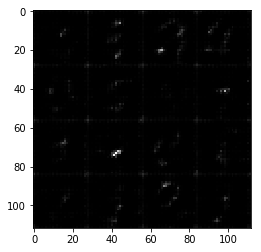

Generator Loss: 0.216 || Discriminator Loss: 1.677
Generator Loss: 0.265 || Discriminator Loss: 1.964
Generator Loss: 0.466 || Discriminator Loss: 1.451
Generator Loss: 0.337 || Discriminator Loss: 1.675
Generator Loss: 0.206 || Discriminator Loss: 1.935
Generator Loss: 0.082 || Discriminator Loss: 1.692
Generator Loss: 0.082 || Discriminator Loss: 1.967
Generator Loss: 0.246 || Discriminator Loss: 1.272
Generator Loss: 0.164 || Discriminator Loss: 1.466
Generator Loss: 0.192 || Discriminator Loss: 1.663


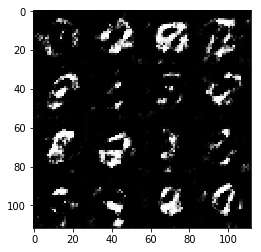

Generator Loss: 0.303 || Discriminator Loss: 1.391
Generator Loss: 0.087 || Discriminator Loss: 1.833
Generator Loss: 0.260 || Discriminator Loss: 1.432
Generator Loss: 0.114 || Discriminator Loss: 1.588
Generator Loss: 0.163 || Discriminator Loss: 1.375
Generator Loss: 0.163 || Discriminator Loss: 1.482
Generator Loss: 0.268 || Discriminator Loss: 1.659
Generator Loss: 0.308 || Discriminator Loss: 1.540
Generator Loss: 0.119 || Discriminator Loss: 1.464
Generator Loss: 0.292 || Discriminator Loss: 1.595


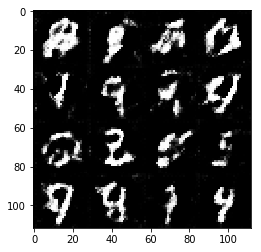

Generator Loss: 0.195 || Discriminator Loss: 1.589
Generator Loss: 0.210 || Discriminator Loss: 1.675
Generator Loss: 0.180 || Discriminator Loss: 1.247
Generator Loss: 0.448 || Discriminator Loss: 1.477
Generator Loss: 0.134 || Discriminator Loss: 1.582
Generator Loss: 0.153 || Discriminator Loss: 1.529
Generator Loss: 0.185 || Discriminator Loss: 1.343
Generator Loss: 0.263 || Discriminator Loss: 1.602
Generator Loss: 0.057 || Discriminator Loss: 1.608
Generator Loss: 0.076 || Discriminator Loss: 1.802


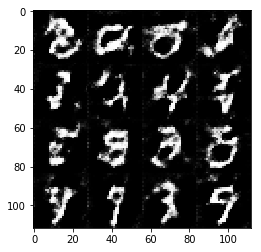

Generator Loss: 0.122 || Discriminator Loss: 1.455
Generator Loss: 0.323 || Discriminator Loss: 1.294
Generator Loss: 0.107 || Discriminator Loss: 1.726
Generator Loss: 0.134 || Discriminator Loss: 1.566
Generator Loss: 0.146 || Discriminator Loss: 1.564
Generator Loss: 0.217 || Discriminator Loss: 1.235
Generator Loss: 0.275 || Discriminator Loss: 1.508
Generator Loss: 0.310 || Discriminator Loss: 1.517
Generator Loss: 0.212 || Discriminator Loss: 1.389
Generator Loss: 0.279 || Discriminator Loss: 1.599


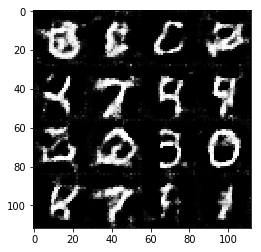

Generator Loss: 0.388 || Discriminator Loss: 1.290
Generator Loss: 0.115 || Discriminator Loss: 1.548
Generator Loss: 0.291 || Discriminator Loss: 1.503
Generator Loss: 0.094 || Discriminator Loss: 1.516
Generator Loss: 0.354 || Discriminator Loss: 1.283
Generator Loss: 0.522 || Discriminator Loss: 1.144
Generator Loss: 0.202 || Discriminator Loss: 1.463
Generator Loss: 0.195 || Discriminator Loss: 1.222
Generator Loss: 0.223 || Discriminator Loss: 1.265
Generator Loss: 0.282 || Discriminator Loss: 1.325


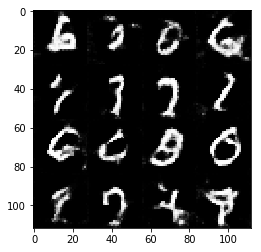

Generator Loss: 0.150 || Discriminator Loss: 1.596
Generator Loss: 0.273 || Discriminator Loss: 1.635
Generator Loss: 0.239 || Discriminator Loss: 1.650
Generator Loss: 0.273 || Discriminator Loss: 1.715
Generator Loss: 0.352 || Discriminator Loss: 1.593
Generator Loss: 0.346 || Discriminator Loss: 1.374
Generator Loss: 0.149 || Discriminator Loss: 1.471
Generator Loss: 0.307 || Discriminator Loss: 1.351
Generator Loss: 0.232 || Discriminator Loss: 1.413
Generator Loss: 0.221 || Discriminator Loss: 1.542


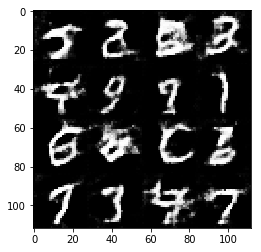

Generator Loss: 0.196 || Discriminator Loss: 1.346
Generator Loss: 0.180 || Discriminator Loss: 1.499
Generator Loss: 0.514 || Discriminator Loss: 1.284
Generator Loss: 0.407 || Discriminator Loss: 1.443
Generator Loss: 0.411 || Discriminator Loss: 1.298
Generator Loss: 0.247 || Discriminator Loss: 1.504
Generator Loss: 0.344 || Discriminator Loss: 1.190
Generator Loss: 0.302 || Discriminator Loss: 1.132
Generator Loss: 0.151 || Discriminator Loss: 1.336
Generator Loss: 0.168 || Discriminator Loss: 1.488


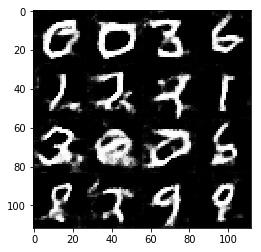

Generator Loss: 0.308 || Discriminator Loss: 1.506
Generator Loss: 0.440 || Discriminator Loss: 1.411
Generator Loss: 0.368 || Discriminator Loss: 1.673
Generator Loss: 0.221 || Discriminator Loss: 1.277
Generator Loss: 0.228 || Discriminator Loss: 1.481
Generator Loss: 0.139 || Discriminator Loss: 1.439
Generator Loss: 0.241 || Discriminator Loss: 1.425
Generator Loss: 0.352 || Discriminator Loss: 1.665
Generator Loss: 0.157 || Discriminator Loss: 1.471
Generator Loss: 0.184 || Discriminator Loss: 1.590


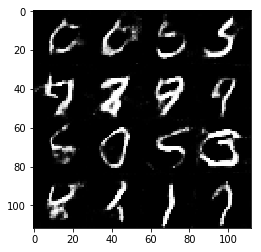

Generator Loss: 0.243 || Discriminator Loss: 1.244
Generator Loss: 0.168 || Discriminator Loss: 1.327
Generator Loss: 0.230 || Discriminator Loss: 1.498
Generator Loss: 0.265 || Discriminator Loss: 1.482
Generator Loss: 0.154 || Discriminator Loss: 1.411
Generator Loss: 0.154 || Discriminator Loss: 1.300
Generator Loss: 0.142 || Discriminator Loss: 1.337
Generator Loss: 0.258 || Discriminator Loss: 1.202
Generator Loss: 0.177 || Discriminator Loss: 1.284
Generator Loss: 0.261 || Discriminator Loss: 1.424


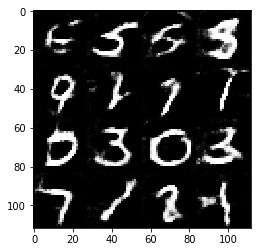

Generator Loss: 0.213 || Discriminator Loss: 1.402
Generator Loss: 0.209 || Discriminator Loss: 1.434
Generator Loss: 0.300 || Discriminator Loss: 1.431
Generator Loss: 0.177 || Discriminator Loss: 1.384
Generator Loss: 0.259 || Discriminator Loss: 1.308
Generator Loss: 0.241 || Discriminator Loss: 1.358
Generator Loss: 0.183 || Discriminator Loss: 1.349
Generator Loss: 0.380 || Discriminator Loss: 1.533
Generator Loss: 0.182 || Discriminator Loss: 1.355
Generator Loss: 0.160 || Discriminator Loss: 1.480


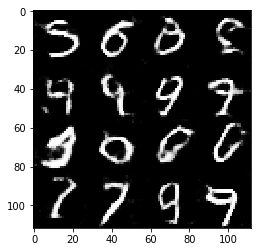

Generator Loss: 0.303 || Discriminator Loss: 1.376
Generator Loss: 0.297 || Discriminator Loss: 1.319
Generator Loss: 0.168 || Discriminator Loss: 1.476
Generator Loss: 0.181 || Discriminator Loss: 1.425
Generator Loss: 0.193 || Discriminator Loss: 1.472
Generator Loss: 0.358 || Discriminator Loss: 1.425
Generator Loss: 0.197 || Discriminator Loss: 1.427
Generator Loss: 0.208 || Discriminator Loss: 1.242
Generator Loss: 0.312 || Discriminator Loss: 1.231
Generator Loss: 0.157 || Discriminator Loss: 1.510


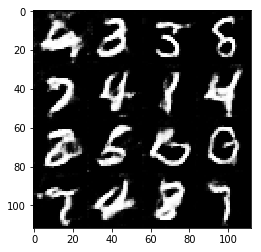

Generator Loss: 0.339 || Discriminator Loss: 1.285
Generator Loss: 0.213 || Discriminator Loss: 1.231
Generator Loss: 0.288 || Discriminator Loss: 1.376
Generator Loss: 0.224 || Discriminator Loss: 1.539
Generator Loss: 0.290 || Discriminator Loss: 1.338
Generator Loss: 0.203 || Discriminator Loss: 1.400
Generator Loss: 0.336 || Discriminator Loss: 1.227
Generator Loss: 0.304 || Discriminator Loss: 1.547
Generator Loss: 0.120 || Discriminator Loss: 1.589
Generator Loss: 0.146 || Discriminator Loss: 1.597


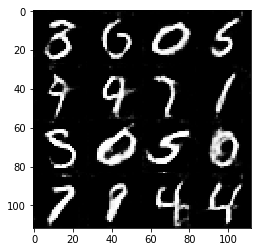

Generator Loss: 0.112 || Discriminator Loss: 1.572
Generator Loss: 0.176 || Discriminator Loss: 1.538
Generator Loss: 0.553 || Discriminator Loss: 1.027
Generator Loss: 0.273 || Discriminator Loss: 1.245
Generator Loss: 0.256 || Discriminator Loss: 1.249
Generator Loss: 0.377 || Discriminator Loss: 1.119
Generator Loss: 0.161 || Discriminator Loss: 1.530
Generator Loss: 0.122 || Discriminator Loss: 1.733
Generator Loss: 0.184 || Discriminator Loss: 1.274
Generator Loss: 0.109 || Discriminator Loss: 1.589


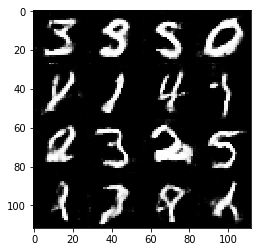

Generator Loss: 0.397 || Discriminator Loss: 1.492
Generator Loss: 0.172 || Discriminator Loss: 1.368
Generator Loss: 0.154 || Discriminator Loss: 1.391
Generator Loss: 0.206 || Discriminator Loss: 1.233
Generator Loss: 0.179 || Discriminator Loss: 1.470
Generator Loss: 0.140 || Discriminator Loss: 1.344
Generator Loss: 0.133 || Discriminator Loss: 1.606
Generator Loss: 0.288 || Discriminator Loss: 1.174
Generator Loss: 0.250 || Discriminator Loss: 1.370
Generator Loss: 0.258 || Discriminator Loss: 1.541


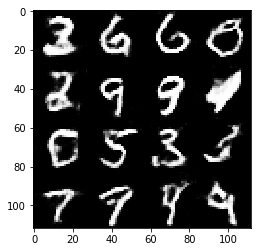

Generator Loss: 0.373 || Discriminator Loss: 1.395
Generator Loss: 0.196 || Discriminator Loss: 1.338
Generator Loss: 0.434 || Discriminator Loss: 1.348
Generator Loss: 0.154 || Discriminator Loss: 1.489
Generator Loss: 0.285 || Discriminator Loss: 1.345
Generator Loss: 0.118 || Discriminator Loss: 1.409
Generator Loss: 0.307 || Discriminator Loss: 1.396
Generator Loss: 0.264 || Discriminator Loss: 1.317
Generator Loss: 0.091 || Discriminator Loss: 1.648
Generator Loss: 0.311 || Discriminator Loss: 1.392


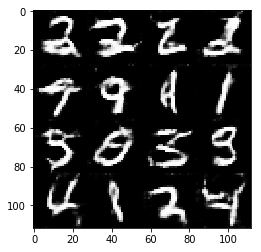

Generator Loss: 0.294 || Discriminator Loss: 1.555
Generator Loss: 0.128 || Discriminator Loss: 1.455
Generator Loss: 0.202 || Discriminator Loss: 1.487
Generator Loss: 0.178 || Discriminator Loss: 1.451
Generator Loss: 0.399 || Discriminator Loss: 1.246
Generator Loss: 0.154 || Discriminator Loss: 1.484
Generator Loss: 0.548 || Discriminator Loss: 0.946
Generator Loss: 0.319 || Discriminator Loss: 1.274
Generator Loss: 0.292 || Discriminator Loss: 1.487
Generator Loss: 0.183 || Discriminator Loss: 1.417


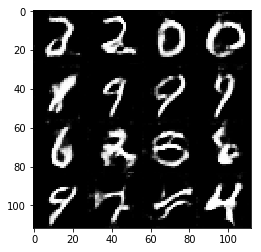

Generator Loss: 0.329 || Discriminator Loss: 1.267
Generator Loss: 0.467 || Discriminator Loss: 1.254
Generator Loss: 0.353 || Discriminator Loss: 1.326
Generator Loss: 0.321 || Discriminator Loss: 1.092
Generator Loss: 0.164 || Discriminator Loss: 1.414
Generator Loss: 0.451 || Discriminator Loss: 1.291
Generator Loss: 0.244 || Discriminator Loss: 1.330
Generator Loss: 0.354 || Discriminator Loss: 1.435
Generator Loss: 0.453 || Discriminator Loss: 1.113
Generator Loss: 0.203 || Discriminator Loss: 1.520


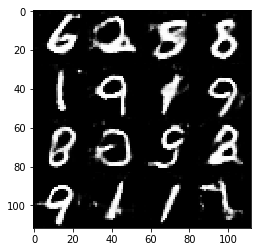

Generator Loss: 0.340 || Discriminator Loss: 0.910
Generator Loss: 0.289 || Discriminator Loss: 1.206
Generator Loss: 0.475 || Discriminator Loss: 1.333
Generator Loss: 0.226 || Discriminator Loss: 1.413
Generator Loss: 0.176 || Discriminator Loss: 1.559
Generator Loss: 0.272 || Discriminator Loss: 1.407
Generator Loss: 0.355 || Discriminator Loss: 1.357
Generator Loss: 0.287 || Discriminator Loss: 1.333
Generator Loss: 0.291 || Discriminator Loss: 1.387
Generator Loss: 0.335 || Discriminator Loss: 1.424


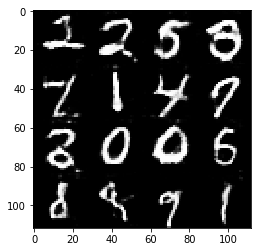

Generator Loss: 0.238 || Discriminator Loss: 1.354
Generator Loss: 0.203 || Discriminator Loss: 1.395
Generator Loss: 0.269 || Discriminator Loss: 1.378
Generator Loss: 0.189 || Discriminator Loss: 1.387
Generator Loss: 0.246 || Discriminator Loss: 1.127
Generator Loss: 0.243 || Discriminator Loss: 1.315
Generator Loss: 0.282 || Discriminator Loss: 1.264
Generator Loss: 0.224 || Discriminator Loss: 1.286
Generator Loss: 0.537 || Discriminator Loss: 1.136
Generator Loss: 0.380 || Discriminator Loss: 1.245


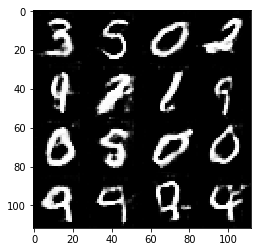

Generator Loss: 0.225 || Discriminator Loss: 1.323
Generator Loss: 0.436 || Discriminator Loss: 1.306
Generator Loss: 0.356 || Discriminator Loss: 1.448
Generator Loss: 0.362 || Discriminator Loss: 1.435
Generator Loss: 0.446 || Discriminator Loss: 1.301
Generator Loss: 0.284 || Discriminator Loss: 1.266
Generator Loss: 0.229 || Discriminator Loss: 1.219
Generator Loss: 0.285 || Discriminator Loss: 1.247
Generator Loss: 0.259 || Discriminator Loss: 1.303
Generator Loss: 0.181 || Discriminator Loss: 1.415


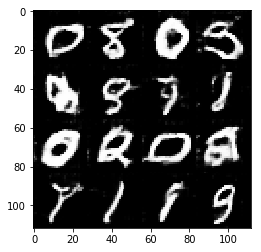

Generator Loss: 0.488 || Discriminator Loss: 1.084
Generator Loss: 0.240 || Discriminator Loss: 1.343
Generator Loss: 0.153 || Discriminator Loss: 1.351
Generator Loss: 0.056 || Discriminator Loss: 1.717
Generator Loss: 0.288 || Discriminator Loss: 1.233
Generator Loss: 0.387 || Discriminator Loss: 0.998
Generator Loss: 0.114 || Discriminator Loss: 1.508
Generator Loss: 0.353 || Discriminator Loss: 1.405
Generator Loss: 0.197 || Discriminator Loss: 1.155
Generator Loss: 0.190 || Discriminator Loss: 1.247


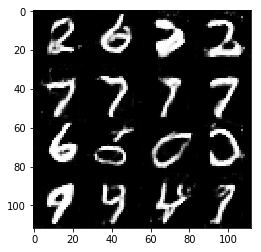

Generator Loss: 0.187 || Discriminator Loss: 1.263
Generator Loss: 0.112 || Discriminator Loss: 1.608
Generator Loss: 0.326 || Discriminator Loss: 1.132
Generator Loss: 0.280 || Discriminator Loss: 1.247
Generator Loss: 0.386 || Discriminator Loss: 1.343
Generator Loss: 0.301 || Discriminator Loss: 1.111
Generator Loss: 0.176 || Discriminator Loss: 1.367
Generator Loss: 0.222 || Discriminator Loss: 1.311
Generator Loss: 0.220 || Discriminator Loss: 1.501
Generator Loss: 0.109 || Discriminator Loss: 1.620


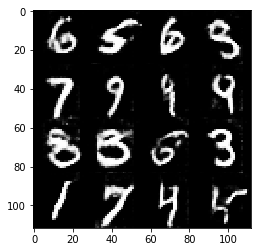

Generator Loss: 0.355 || Discriminator Loss: 1.459
Generator Loss: 0.358 || Discriminator Loss: 1.396
Generator Loss: 0.196 || Discriminator Loss: 1.346
Generator Loss: 0.306 || Discriminator Loss: 1.261
Generator Loss: 0.435 || Discriminator Loss: 1.270
Generator Loss: 0.147 || Discriminator Loss: 1.397
Generator Loss: 0.228 || Discriminator Loss: 1.667
Generator Loss: 0.289 || Discriminator Loss: 1.365
Generator Loss: 0.192 || Discriminator Loss: 1.477
Generator Loss: 0.202 || Discriminator Loss: 1.420


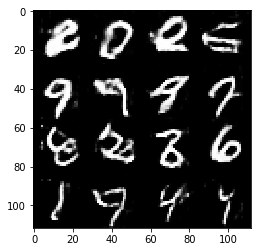

Generator Loss: 0.333 || Discriminator Loss: 1.528
Generator Loss: 0.196 || Discriminator Loss: 1.532
Generator Loss: 0.274 || Discriminator Loss: 1.218
Generator Loss: 0.187 || Discriminator Loss: 1.528
Generator Loss: 0.299 || Discriminator Loss: 1.177
Generator Loss: 0.152 || Discriminator Loss: 1.616
Generator Loss: 0.225 || Discriminator Loss: 1.230
Generator Loss: 0.191 || Discriminator Loss: 1.467
Generator Loss: 0.316 || Discriminator Loss: 1.314
Generator Loss: 0.315 || Discriminator Loss: 1.240


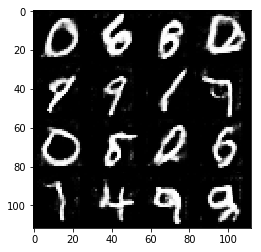

Generator Loss: 0.167 || Discriminator Loss: 1.420
Generator Loss: 0.133 || Discriminator Loss: 1.639
Generator Loss: 0.334 || Discriminator Loss: 1.187
Generator Loss: 0.260 || Discriminator Loss: 1.372
Generator Loss: 0.245 || Discriminator Loss: 1.096
Generator Loss: 0.334 || Discriminator Loss: 1.274
Generator Loss: 0.270 || Discriminator Loss: 1.367
Generator Loss: 0.162 || Discriminator Loss: 1.531
Generator Loss: 0.226 || Discriminator Loss: 1.172
Generator Loss: 0.387 || Discriminator Loss: 1.143


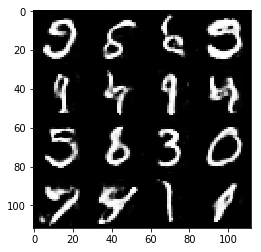

Generator Loss: 0.286 || Discriminator Loss: 1.162
Generator Loss: 0.205 || Discriminator Loss: 1.615
Generator Loss: 0.367 || Discriminator Loss: 1.036
Generator Loss: 0.260 || Discriminator Loss: 1.517
Generator Loss: 0.293 || Discriminator Loss: 1.463
Generator Loss: 0.289 || Discriminator Loss: 1.306
Generator Loss: 0.393 || Discriminator Loss: 1.236
Generator Loss: 0.397 || Discriminator Loss: 1.174
Generator Loss: 0.299 || Discriminator Loss: 1.364
Generator Loss: 0.348 || Discriminator Loss: 1.338


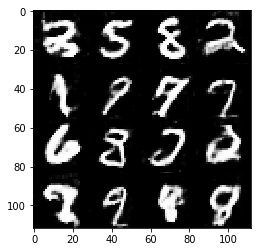

Generator Loss: 0.272 || Discriminator Loss: 1.075
Generator Loss: 0.239 || Discriminator Loss: 1.378
Generator Loss: 0.436 || Discriminator Loss: 1.180
Generator Loss: 0.160 || Discriminator Loss: 1.515
Generator Loss: 0.340 || Discriminator Loss: 1.163
Generator Loss: 0.283 || Discriminator Loss: 1.300
Generator Loss: 0.359 || Discriminator Loss: 1.500
Generator Loss: 0.282 || Discriminator Loss: 1.106
Generator Loss: 0.237 || Discriminator Loss: 1.524
Generator Loss: 0.323 || Discriminator Loss: 1.075


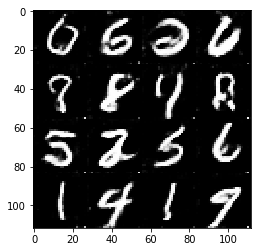

Generator Loss: 0.207 || Discriminator Loss: 1.299
Generator Loss: 0.206 || Discriminator Loss: 1.491
Generator Loss: 0.170 || Discriminator Loss: 1.455
Generator Loss: 0.188 || Discriminator Loss: 1.305
Generator Loss: 0.187 || Discriminator Loss: 1.318
Generator Loss: 0.350 || Discriminator Loss: 1.245
Generator Loss: 0.232 || Discriminator Loss: 1.176
Generator Loss: 0.454 || Discriminator Loss: 1.222
Generator Loss: 0.371 || Discriminator Loss: 1.207
Generator Loss: 0.171 || Discriminator Loss: 1.299


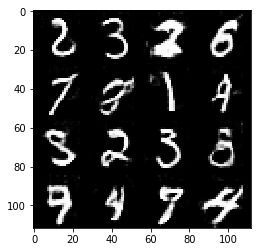

Generator Loss: 0.347 || Discriminator Loss: 1.320
Generator Loss: 0.274 || Discriminator Loss: 1.646
Generator Loss: 0.353 || Discriminator Loss: 1.146
Generator Loss: 0.269 || Discriminator Loss: 1.303
Generator Loss: 0.229 || Discriminator Loss: 1.185
Generator Loss: 0.367 || Discriminator Loss: 1.091
Generator Loss: 0.189 || Discriminator Loss: 1.463
Generator Loss: 0.416 || Discriminator Loss: 1.114
Generator Loss: 0.410 || Discriminator Loss: 1.349
Generator Loss: 0.187 || Discriminator Loss: 1.340


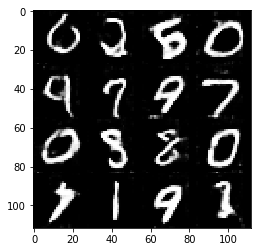

Generator Loss: 0.326 || Discriminator Loss: 1.261
Generator Loss: 0.315 || Discriminator Loss: 1.283
Generator Loss: 0.200 || Discriminator Loss: 1.470
Generator Loss: 0.242 || Discriminator Loss: 1.287
Generator Loss: 0.273 || Discriminator Loss: 1.260
Generator Loss: 0.157 || Discriminator Loss: 1.352
Generator Loss: 0.346 || Discriminator Loss: 1.307
Generator Loss: 0.360 || Discriminator Loss: 1.357
Generator Loss: 0.318 || Discriminator Loss: 1.069
Generator Loss: 0.389 || Discriminator Loss: 0.988


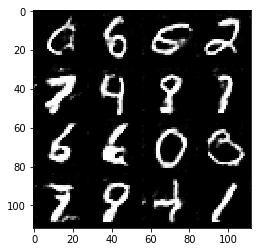

Generator Loss: 0.296 || Discriminator Loss: 0.936
Generator Loss: 0.221 || Discriminator Loss: 1.379
Generator Loss: 0.251 || Discriminator Loss: 1.172
Generator Loss: 0.296 || Discriminator Loss: 1.068
Generator Loss: 0.259 || Discriminator Loss: 1.105
Generator Loss: 0.633 || Discriminator Loss: 1.211
Generator Loss: 0.133 || Discriminator Loss: 1.323
Generator Loss: 0.527 || Discriminator Loss: 0.987
Generator Loss: 0.329 || Discriminator Loss: 1.121
Generator Loss: 0.262 || Discriminator Loss: 1.325


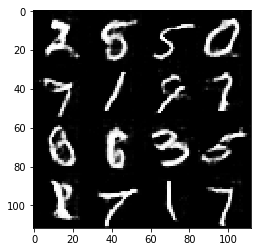

Generator Loss: 0.171 || Discriminator Loss: 1.393
Generator Loss: 0.175 || Discriminator Loss: 1.325
Generator Loss: 0.310 || Discriminator Loss: 1.332
Generator Loss: 0.303 || Discriminator Loss: 1.470
Generator Loss: 0.349 || Discriminator Loss: 1.341
Generator Loss: 0.145 || Discriminator Loss: 1.496
Generator Loss: 0.262 || Discriminator Loss: 1.364
Generator Loss: 0.220 || Discriminator Loss: 1.254
Generator Loss: 0.313 || Discriminator Loss: 1.303
Generator Loss: 0.347 || Discriminator Loss: 1.127


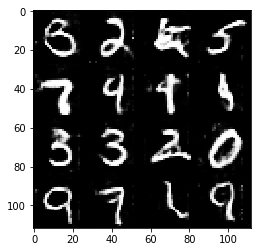

Generator Loss: 0.222 || Discriminator Loss: 1.172
Generator Loss: 0.295 || Discriminator Loss: 1.175
Generator Loss: 0.222 || Discriminator Loss: 1.303
Generator Loss: 0.244 || Discriminator Loss: 1.229
Generator Loss: 0.349 || Discriminator Loss: 1.200
Generator Loss: 0.189 || Discriminator Loss: 1.572
Generator Loss: 0.358 || Discriminator Loss: 1.297
Generator Loss: 0.323 || Discriminator Loss: 1.182
Generator Loss: 0.317 || Discriminator Loss: 1.232
Generator Loss: 0.442 || Discriminator Loss: 1.157


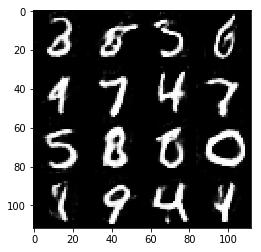

Generator Loss: 0.413 || Discriminator Loss: 1.126
Generator Loss: 0.152 || Discriminator Loss: 1.357
Generator Loss: 0.251 || Discriminator Loss: 1.366
Generator Loss: 0.391 || Discriminator Loss: 0.959
Generator Loss: 0.229 || Discriminator Loss: 1.338
Generator Loss: 0.370 || Discriminator Loss: 1.143
Generator Loss: 0.307 || Discriminator Loss: 1.191
Generator Loss: 0.319 || Discriminator Loss: 1.301
Generator Loss: 0.320 || Discriminator Loss: 1.316
Generator Loss: 0.431 || Discriminator Loss: 1.066


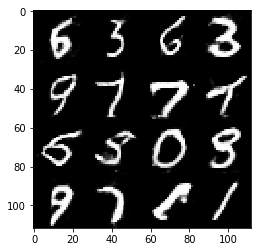

Generator Loss: 0.194 || Discriminator Loss: 1.268
Generator Loss: 0.228 || Discriminator Loss: 1.079
Generator Loss: 0.184 || Discriminator Loss: 1.368
Generator Loss: 0.392 || Discriminator Loss: 1.226
Generator Loss: 0.371 || Discriminator Loss: 1.171
Generator Loss: 0.315 || Discriminator Loss: 1.251
Generator Loss: 0.360 || Discriminator Loss: 1.410
Generator Loss: 0.318 || Discriminator Loss: 1.243
Generator Loss: 0.251 || Discriminator Loss: 1.318
Generator Loss: 0.175 || Discriminator Loss: 1.433


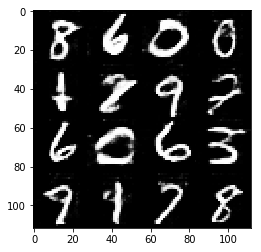

Generator Loss: 0.250 || Discriminator Loss: 0.933
Generator Loss: 0.133 || Discriminator Loss: 1.452
Generator Loss: 0.388 || Discriminator Loss: 1.236
Generator Loss: 0.234 || Discriminator Loss: 1.281
Generator Loss: 0.501 || Discriminator Loss: 0.970
Generator Loss: 0.358 || Discriminator Loss: 1.210
Generator Loss: 0.231 || Discriminator Loss: 1.335
Generator Loss: 0.301 || Discriminator Loss: 1.156
Generator Loss: 0.249 || Discriminator Loss: 1.351
Generator Loss: 0.161 || Discriminator Loss: 1.377


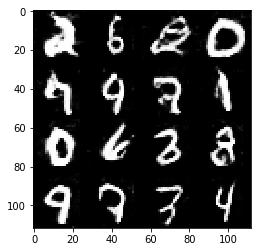

Generator Loss: 0.196 || Discriminator Loss: 1.498
Generator Loss: 0.375 || Discriminator Loss: 1.358
Generator Loss: 0.235 || Discriminator Loss: 1.229
Generator Loss: 0.472 || Discriminator Loss: 1.256
Generator Loss: 0.326 || Discriminator Loss: 1.323
Generator Loss: 0.504 || Discriminator Loss: 1.029
Generator Loss: 0.302 || Discriminator Loss: 1.157
Generator Loss: 0.192 || Discriminator Loss: 1.299
Generator Loss: 0.383 || Discriminator Loss: 1.240
Generator Loss: 0.343 || Discriminator Loss: 1.199


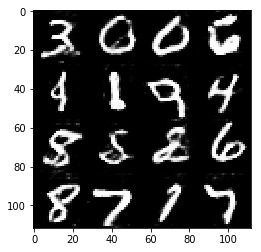

Generator Loss: 0.200 || Discriminator Loss: 1.397
Generator Loss: 0.335 || Discriminator Loss: 1.178
Generator Loss: 0.248 || Discriminator Loss: 1.221
Generator Loss: 0.391 || Discriminator Loss: 1.074
Generator Loss: 0.464 || Discriminator Loss: 1.148
Generator Loss: 0.273 || Discriminator Loss: 1.260
Generator Loss: 0.284 || Discriminator Loss: 1.408
Generator Loss: 0.185 || Discriminator Loss: 1.283
Generator Loss: 0.325 || Discriminator Loss: 1.184
Generator Loss: 0.332 || Discriminator Loss: 1.194


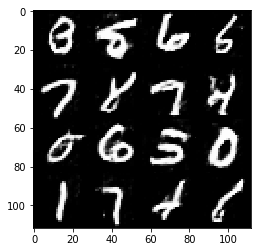

Generator Loss: 0.464 || Discriminator Loss: 1.387
Generator Loss: 0.206 || Discriminator Loss: 1.300
Generator Loss: 0.100 || Discriminator Loss: 1.474
Generator Loss: 0.286 || Discriminator Loss: 1.303
Generator Loss: 0.520 || Discriminator Loss: 1.234
Generator Loss: 0.234 || Discriminator Loss: 1.185
Generator Loss: 0.360 || Discriminator Loss: 1.155
Generator Loss: 0.299 || Discriminator Loss: 1.352
Generator Loss: 0.161 || Discriminator Loss: 1.324
Generator Loss: 0.244 || Discriminator Loss: 1.049


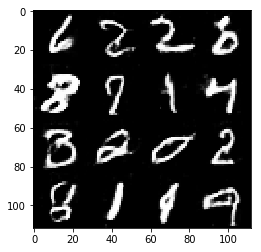

Generator Loss: 0.307 || Discriminator Loss: 1.253
Generator Loss: 0.319 || Discriminator Loss: 1.258
Generator Loss: 0.098 || Discriminator Loss: 1.439
Generator Loss: 0.401 || Discriminator Loss: 1.046
Generator Loss: 0.223 || Discriminator Loss: 1.457
Generator Loss: 0.317 || Discriminator Loss: 1.308
Generator Loss: 0.315 || Discriminator Loss: 1.197
Generator Loss: 0.312 || Discriminator Loss: 0.948
Generator Loss: 0.418 || Discriminator Loss: 1.312
Generator Loss: 0.293 || Discriminator Loss: 1.358


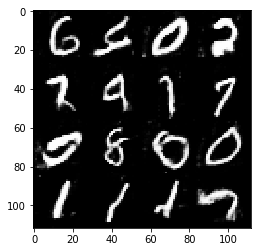

Generator Loss: 0.332 || Discriminator Loss: 1.232
Generator Loss: 0.502 || Discriminator Loss: 1.099
Generator Loss: 0.227 || Discriminator Loss: 1.168
Generator Loss: 0.236 || Discriminator Loss: 1.180
Generator Loss: 0.152 || Discriminator Loss: 1.487
Generator Loss: 0.358 || Discriminator Loss: 1.251
Generator Loss: 0.311 || Discriminator Loss: 1.148
Generator Loss: 0.158 || Discriminator Loss: 1.354
Generator Loss: 0.234 || Discriminator Loss: 1.163
Generator Loss: 0.149 || Discriminator Loss: 1.393


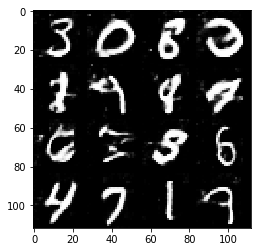

Generator Loss: 0.316 || Discriminator Loss: 1.189
Generator Loss: 0.242 || Discriminator Loss: 1.123
Generator Loss: 0.403 || Discriminator Loss: 1.158
Generator Loss: 0.347 || Discriminator Loss: 0.837
Generator Loss: 0.183 || Discriminator Loss: 1.250
Generator Loss: 0.317 || Discriminator Loss: 1.070
Generator Loss: 0.270 || Discriminator Loss: 1.298
Generator Loss: 0.254 || Discriminator Loss: 1.317
Generator Loss: 0.297 || Discriminator Loss: 0.848
Generator Loss: 0.297 || Discriminator Loss: 1.033


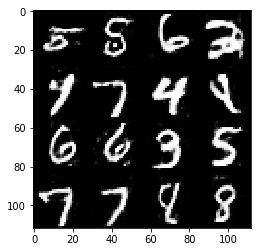

Generator Loss: 0.307 || Discriminator Loss: 1.463
Generator Loss: 0.396 || Discriminator Loss: 0.936
Generator Loss: 0.460 || Discriminator Loss: 1.080
Generator Loss: 0.336 || Discriminator Loss: 1.301
Generator Loss: 0.201 || Discriminator Loss: 1.397
Generator Loss: 0.223 || Discriminator Loss: 1.084
Generator Loss: 0.733 || Discriminator Loss: 0.891
Generator Loss: 0.131 || Discriminator Loss: 1.505
Generator Loss: 0.175 || Discriminator Loss: 1.473
Generator Loss: 0.386 || Discriminator Loss: 1.148


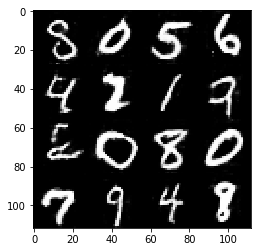

Generator Loss: 0.423 || Discriminator Loss: 1.049
Generator Loss: 0.183 || Discriminator Loss: 1.372
Generator Loss: 0.198 || Discriminator Loss: 1.370
Generator Loss: 0.161 || Discriminator Loss: 1.354
Generator Loss: 0.291 || Discriminator Loss: 1.057
Generator Loss: 0.552 || Discriminator Loss: 0.889
Generator Loss: 0.376 || Discriminator Loss: 0.994
Generator Loss: 0.225 || Discriminator Loss: 1.426
Generator Loss: 0.323 || Discriminator Loss: 1.013
Generator Loss: 0.317 || Discriminator Loss: 1.031


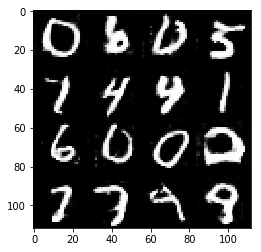

Generator Loss: 0.382 || Discriminator Loss: 1.088
Generator Loss: 0.365 || Discriminator Loss: 1.164
Generator Loss: 0.258 || Discriminator Loss: 0.996
Generator Loss: 0.398 || Discriminator Loss: 1.030
Generator Loss: 0.230 || Discriminator Loss: 1.176
Generator Loss: 0.154 || Discriminator Loss: 1.364
Generator Loss: 0.596 || Discriminator Loss: 1.030
Generator Loss: 0.334 || Discriminator Loss: 1.433
Generator Loss: 0.431 || Discriminator Loss: 1.262
Generator Loss: 0.251 || Discriminator Loss: 1.503


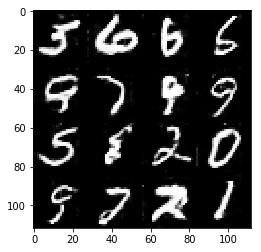

Generator Loss: 0.388 || Discriminator Loss: 1.216
Generator Loss: 0.134 || Discriminator Loss: 1.223
Generator Loss: 0.269 || Discriminator Loss: 1.133
Generator Loss: 0.446 || Discriminator Loss: 1.236
Generator Loss: 0.415 || Discriminator Loss: 1.083
Generator Loss: 0.274 || Discriminator Loss: 0.804
Generator Loss: 0.319 || Discriminator Loss: 0.904
Generator Loss: 0.363 || Discriminator Loss: 0.914
Generator Loss: 0.322 || Discriminator Loss: 1.045
Generator Loss: 0.176 || Discriminator Loss: 1.437


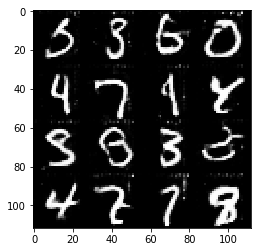

Generator Loss: 0.260 || Discriminator Loss: 1.278
Generator Loss: 0.140 || Discriminator Loss: 1.089
Generator Loss: 0.351 || Discriminator Loss: 1.091
Generator Loss: 0.394 || Discriminator Loss: 1.121
Generator Loss: 0.207 || Discriminator Loss: 1.050
Generator Loss: 0.420 || Discriminator Loss: 1.032
Generator Loss: 0.480 || Discriminator Loss: 0.930
Generator Loss: 0.442 || Discriminator Loss: 0.881
Generator Loss: 0.440 || Discriminator Loss: 1.034
Generator Loss: 0.313 || Discriminator Loss: 1.093


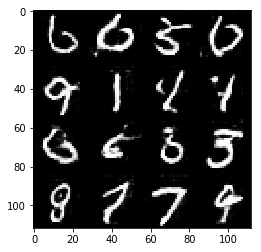

Generator Loss: 0.512 || Discriminator Loss: 1.255
Generator Loss: 0.425 || Discriminator Loss: 0.714
Generator Loss: 0.394 || Discriminator Loss: 1.307
Generator Loss: 0.335 || Discriminator Loss: 0.962
Generator Loss: 0.172 || Discriminator Loss: 1.336
Generator Loss: 0.206 || Discriminator Loss: 1.195
Generator Loss: 0.463 || Discriminator Loss: 1.138
Generator Loss: 0.453 || Discriminator Loss: 1.272
Generator Loss: 0.247 || Discriminator Loss: 1.185
Generator Loss: 0.192 || Discriminator Loss: 1.152


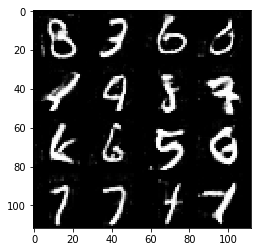

Generator Loss: 0.276 || Discriminator Loss: 1.098
Generator Loss: 0.217 || Discriminator Loss: 0.981
Generator Loss: 0.310 || Discriminator Loss: 1.056
Generator Loss: 0.270 || Discriminator Loss: 1.054
Generator Loss: 0.206 || Discriminator Loss: 1.251
Generator Loss: 0.241 || Discriminator Loss: 1.163
Generator Loss: 0.285 || Discriminator Loss: 1.037
Generator Loss: 0.115 || Discriminator Loss: 1.315
Generator Loss: 0.154 || Discriminator Loss: 1.515
Generator Loss: 0.271 || Discriminator Loss: 1.026


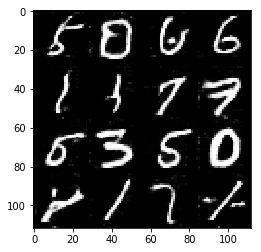

Generator Loss: 0.172 || Discriminator Loss: 1.038
Generator Loss: 0.126 || Discriminator Loss: 1.321
Generator Loss: 0.343 || Discriminator Loss: 1.177
Generator Loss: 0.408 || Discriminator Loss: 0.968
Generator Loss: 0.152 || Discriminator Loss: 1.298
Generator Loss: 0.253 || Discriminator Loss: 1.071
Generator Loss: 0.239 || Discriminator Loss: 1.299
Generator Loss: 0.668 || Discriminator Loss: 0.849
Generator Loss: 0.234 || Discriminator Loss: 1.086
Generator Loss: 0.337 || Discriminator Loss: 1.110


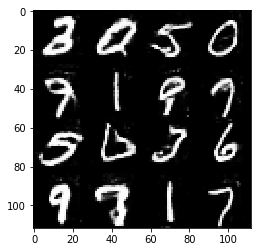

Generator Loss: 0.346 || Discriminator Loss: 1.260
Generator Loss: 0.143 || Discriminator Loss: 1.247
Generator Loss: 0.287 || Discriminator Loss: 1.389
Generator Loss: 0.271 || Discriminator Loss: 1.116
Generator Loss: 0.289 || Discriminator Loss: 1.381
Generator Loss: 0.237 || Discriminator Loss: 1.326
Generator Loss: 0.562 || Discriminator Loss: 0.961
Generator Loss: 0.753 || Discriminator Loss: 1.152
Generator Loss: 0.433 || Discriminator Loss: 1.187
Generator Loss: 0.209 || Discriminator Loss: 1.247


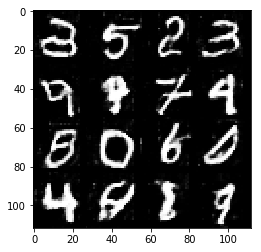

Generator Loss: 0.253 || Discriminator Loss: 0.951
Generator Loss: 0.316 || Discriminator Loss: 1.116
Generator Loss: 0.278 || Discriminator Loss: 1.072
Generator Loss: 0.255 || Discriminator Loss: 1.202
Generator Loss: 0.449 || Discriminator Loss: 1.177
Generator Loss: 0.159 || Discriminator Loss: 1.299
Generator Loss: 0.394 || Discriminator Loss: 1.147
Generator Loss: 0.203 || Discriminator Loss: 1.051
Generator Loss: 0.164 || Discriminator Loss: 1.201
Generator Loss: 0.156 || Discriminator Loss: 1.547


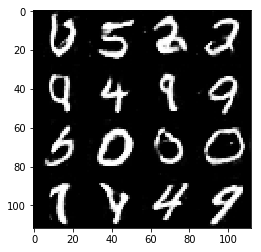

Generator Loss: 0.623 || Discriminator Loss: 0.859
Generator Loss: 0.404 || Discriminator Loss: 1.089
Generator Loss: 0.497 || Discriminator Loss: 0.902
Generator Loss: 0.391 || Discriminator Loss: 1.081
Generator Loss: 0.391 || Discriminator Loss: 1.086
Generator Loss: 0.467 || Discriminator Loss: 1.087
Generator Loss: 0.305 || Discriminator Loss: 1.032
Generator Loss: 0.198 || Discriminator Loss: 1.330
Generator Loss: 0.246 || Discriminator Loss: 1.118
Generator Loss: 0.128 || Discriminator Loss: 1.419


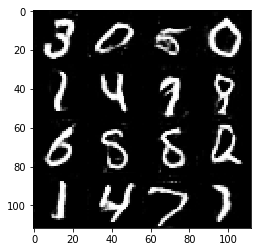

Generator Loss: 0.207 || Discriminator Loss: 1.082
Generator Loss: 0.500 || Discriminator Loss: 0.996
Generator Loss: 0.430 || Discriminator Loss: 1.277
Generator Loss: 0.297 || Discriminator Loss: 1.180
Generator Loss: 0.226 || Discriminator Loss: 1.355
Generator Loss: 0.844 || Discriminator Loss: 0.749
Generator Loss: 0.426 || Discriminator Loss: 0.921
Generator Loss: 0.392 || Discriminator Loss: 1.077
Generator Loss: 0.412 || Discriminator Loss: 0.725
Generator Loss: 0.533 || Discriminator Loss: 1.152


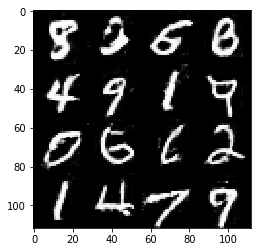

Generator Loss: 0.605 || Discriminator Loss: 0.839
Generator Loss: 0.321 || Discriminator Loss: 1.051
Generator Loss: 0.311 || Discriminator Loss: 0.893
Generator Loss: 0.495 || Discriminator Loss: 0.949
Generator Loss: 0.207 || Discriminator Loss: 0.989
Generator Loss: 0.526 || Discriminator Loss: 0.785
Generator Loss: 0.372 || Discriminator Loss: 1.579
Generator Loss: 0.270 || Discriminator Loss: 0.940
Generator Loss: 0.193 || Discriminator Loss: 1.114
Generator Loss: 0.217 || Discriminator Loss: 1.210


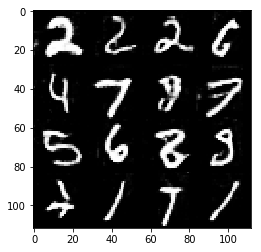

Generator Loss: 0.255 || Discriminator Loss: 0.844
Generator Loss: 0.136 || Discriminator Loss: 1.411
Generator Loss: 0.536 || Discriminator Loss: 0.980
Generator Loss: 0.363 || Discriminator Loss: 1.145
Generator Loss: 0.197 || Discriminator Loss: 0.988
Generator Loss: 0.560 || Discriminator Loss: 1.188
Generator Loss: 0.201 || Discriminator Loss: 1.119
Generator Loss: 0.414 || Discriminator Loss: 0.657
Generator Loss: 0.232 || Discriminator Loss: 1.052
Generator Loss: 0.604 || Discriminator Loss: 0.744


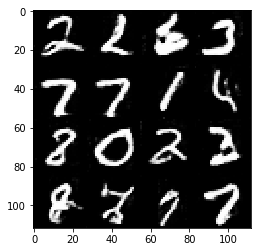

Generator Loss: 0.354 || Discriminator Loss: 0.916
Generator Loss: 0.255 || Discriminator Loss: 1.036
Generator Loss: 0.209 || Discriminator Loss: 0.902
Generator Loss: 0.533 || Discriminator Loss: 1.270
Generator Loss: 0.712 || Discriminator Loss: 0.912
Generator Loss: 0.202 || Discriminator Loss: 1.300
Generator Loss: 0.369 || Discriminator Loss: 0.934
Generator Loss: 0.205 || Discriminator Loss: 1.172
Generator Loss: 0.418 || Discriminator Loss: 0.962
Generator Loss: 0.506 || Discriminator Loss: 1.063


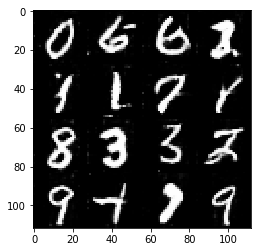

Generator Loss: 0.677 || Discriminator Loss: 1.038
Generator Loss: 0.260 || Discriminator Loss: 1.122
Generator Loss: 0.418 || Discriminator Loss: 1.356
Generator Loss: 0.316 || Discriminator Loss: 0.901
Generator Loss: 0.260 || Discriminator Loss: 0.950
Generator Loss: 0.421 || Discriminator Loss: 1.277
Generator Loss: 0.409 || Discriminator Loss: 0.932
Generator Loss: 0.249 || Discriminator Loss: 1.143
Generator Loss: 0.137 || Discriminator Loss: 1.170
Generator Loss: 0.210 || Discriminator Loss: 1.335


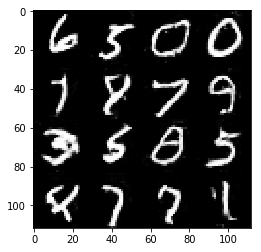

Generator Loss: 0.356 || Discriminator Loss: 0.791
Generator Loss: 0.338 || Discriminator Loss: 0.801
Generator Loss: 0.192 || Discriminator Loss: 1.403
Generator Loss: 0.556 || Discriminator Loss: 0.761
Generator Loss: 0.332 || Discriminator Loss: 0.920
Generator Loss: 0.342 || Discriminator Loss: 0.994
Generator Loss: 0.228 || Discriminator Loss: 1.022
Generator Loss: 0.544 || Discriminator Loss: 0.723
Generator Loss: 0.389 || Discriminator Loss: 0.935
Generator Loss: 0.447 || Discriminator Loss: 1.210


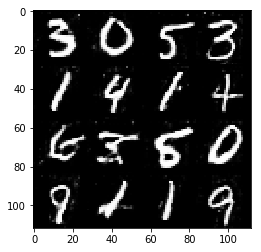

Generator Loss: 0.413 || Discriminator Loss: 1.101
Generator Loss: 0.630 || Discriminator Loss: 0.761
Generator Loss: 0.494 || Discriminator Loss: 0.900
Generator Loss: 0.282 || Discriminator Loss: 1.161
Generator Loss: 0.290 || Discriminator Loss: 1.357
Generator Loss: 0.307 || Discriminator Loss: 1.053
Generator Loss: 0.306 || Discriminator Loss: 0.949
Generator Loss: 0.123 || Discriminator Loss: 1.343
Generator Loss: 0.197 || Discriminator Loss: 1.249
Generator Loss: 0.664 || Discriminator Loss: 0.882


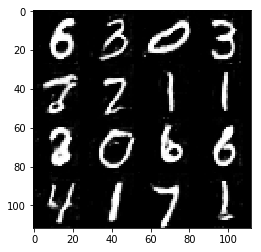

Generator Loss: 0.652 || Discriminator Loss: 1.043
Generator Loss: 0.495 || Discriminator Loss: 1.536
Generator Loss: 0.274 || Discriminator Loss: 1.104
Generator Loss: 0.429 || Discriminator Loss: 0.971
Generator Loss: 0.406 || Discriminator Loss: 0.873
Generator Loss: 0.174 || Discriminator Loss: 1.493
Generator Loss: 0.491 || Discriminator Loss: 0.983
Generator Loss: 0.568 || Discriminator Loss: 0.710
Generator Loss: 0.474 || Discriminator Loss: 1.767
Generator Loss: 0.547 || Discriminator Loss: 0.999


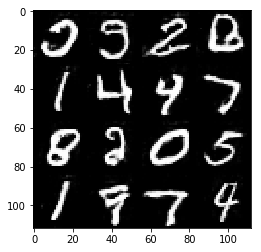

Generator Loss: 0.130 || Discriminator Loss: 1.292
Generator Loss: 0.589 || Discriminator Loss: 1.118
Generator Loss: 0.065 || Discriminator Loss: 1.961
Generator Loss: 0.351 || Discriminator Loss: 1.053
Generator Loss: 0.390 || Discriminator Loss: 0.397
Generator Loss: 0.389 || Discriminator Loss: 0.892
Generator Loss: 0.098 || Discriminator Loss: 1.332
Generator Loss: 0.380 || Discriminator Loss: 0.964
Generator Loss: 0.241 || Discriminator Loss: 1.547
Generator Loss: 0.529 || Discriminator Loss: 0.958


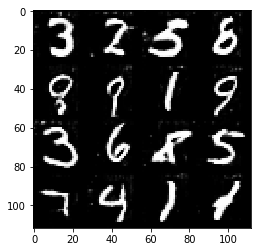

Generator Loss: 0.220 || Discriminator Loss: 1.185
Generator Loss: 0.391 || Discriminator Loss: 0.582
Generator Loss: 0.369 || Discriminator Loss: 0.808
Generator Loss: 0.589 || Discriminator Loss: 0.746
Generator Loss: 0.349 || Discriminator Loss: 0.579
Generator Loss: 0.425 || Discriminator Loss: 0.934
Generator Loss: 0.216 || Discriminator Loss: 1.153
Generator Loss: 0.319 || Discriminator Loss: 0.717
Generator Loss: 0.527 || Discriminator Loss: 1.032
Generator Loss: 0.226 || Discriminator Loss: 1.089


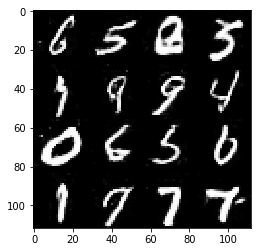

Generator Loss: 0.388 || Discriminator Loss: 1.258
Generator Loss: 0.584 || Discriminator Loss: 1.239
Generator Loss: 0.228 || Discriminator Loss: 0.871
Generator Loss: 0.699 || Discriminator Loss: 0.687
Generator Loss: 0.205 || Discriminator Loss: 0.943
Generator Loss: 0.573 || Discriminator Loss: 0.683
Generator Loss: 0.349 || Discriminator Loss: 1.229
Generator Loss: 0.497 || Discriminator Loss: 0.696
Generator Loss: 0.087 || Discriminator Loss: 1.921
Generator Loss: 0.306 || Discriminator Loss: 1.024


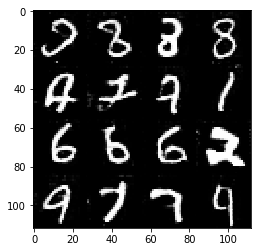

Generator Loss: 0.351 || Discriminator Loss: 0.978
Generator Loss: 0.313 || Discriminator Loss: 0.873
Generator Loss: 0.343 || Discriminator Loss: 0.941
Generator Loss: 0.238 || Discriminator Loss: 0.975
Generator Loss: 0.102 || Discriminator Loss: 1.496
Generator Loss: 0.367 || Discriminator Loss: 0.836
Generator Loss: 0.357 || Discriminator Loss: 1.100
Generator Loss: 0.311 || Discriminator Loss: 1.034
Generator Loss: 0.108 || Discriminator Loss: 1.399
Generator Loss: 0.108 || Discriminator Loss: 1.694


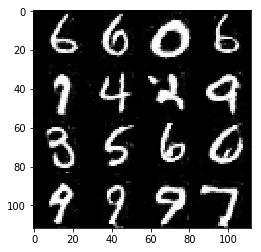

Generator Loss: 0.170 || Discriminator Loss: 1.143
Generator Loss: 0.469 || Discriminator Loss: 0.948
Generator Loss: 0.526 || Discriminator Loss: 1.009
Generator Loss: 0.279 || Discriminator Loss: 0.950
Generator Loss: 0.417 || Discriminator Loss: 1.004
Generator Loss: 0.268 || Discriminator Loss: 0.994
Generator Loss: 0.308 || Discriminator Loss: 0.825
Generator Loss: 0.602 || Discriminator Loss: 0.755
Generator Loss: 0.198 || Discriminator Loss: 1.268
Generator Loss: 0.333 || Discriminator Loss: 0.738


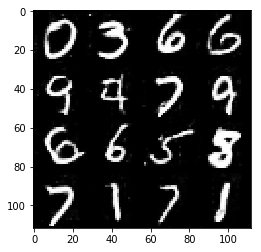

Generator Loss: 0.213 || Discriminator Loss: 1.254
Generator Loss: 0.555 || Discriminator Loss: 0.676
Generator Loss: 0.580 || Discriminator Loss: 0.557
Generator Loss: 0.338 || Discriminator Loss: 1.096
Generator Loss: 0.080 || Discriminator Loss: 1.329
Generator Loss: 0.325 || Discriminator Loss: 1.237
Generator Loss: 0.381 || Discriminator Loss: 0.942
Generator Loss: 0.188 || Discriminator Loss: 1.029
Generator Loss: 0.445 || Discriminator Loss: 0.730
Generator Loss: 0.358 || Discriminator Loss: 1.156


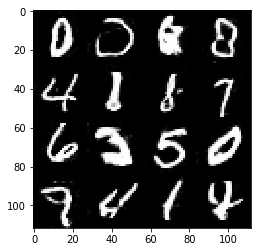

Generator Loss: 0.540 || Discriminator Loss: 0.915
Generator Loss: 0.153 || Discriminator Loss: 1.431
Generator Loss: 0.414 || Discriminator Loss: 0.961
Generator Loss: 0.403 || Discriminator Loss: 0.793
Generator Loss: 0.197 || Discriminator Loss: 0.658
Generator Loss: 0.275 || Discriminator Loss: 0.852
Generator Loss: 0.181 || Discriminator Loss: 1.048
Generator Loss: 0.377 || Discriminator Loss: 1.339
Generator Loss: 0.225 || Discriminator Loss: 0.931
Generator Loss: 0.568 || Discriminator Loss: 0.826


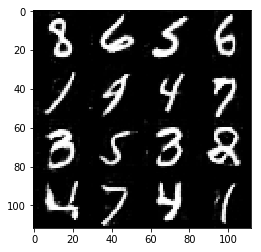

Generator Loss: 0.789 || Discriminator Loss: 0.558
Generator Loss: 0.276 || Discriminator Loss: 0.845
Generator Loss: 0.768 || Discriminator Loss: 0.588
Generator Loss: 0.631 || Discriminator Loss: 0.868
Generator Loss: 0.243 || Discriminator Loss: 1.185
Generator Loss: 0.163 || Discriminator Loss: 1.194
Generator Loss: 0.199 || Discriminator Loss: 1.116
Generator Loss: 0.457 || Discriminator Loss: 0.642
Generator Loss: 0.543 || Discriminator Loss: 1.247
Generator Loss: 0.425 || Discriminator Loss: 0.788


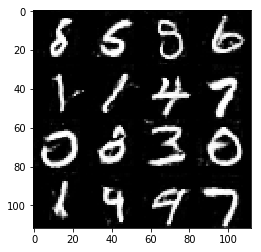

Generator Loss: 0.338 || Discriminator Loss: 0.975
Generator Loss: 0.249 || Discriminator Loss: 1.245
Generator Loss: 0.472 || Discriminator Loss: 0.908
Generator Loss: 0.251 || Discriminator Loss: 1.359
Generator Loss: 0.193 || Discriminator Loss: 1.133
Generator Loss: 0.288 || Discriminator Loss: 1.154
Generator Loss: 0.686 || Discriminator Loss: 0.494
Generator Loss: 0.123 || Discriminator Loss: 1.374
Generator Loss: 0.426 || Discriminator Loss: 0.785
Generator Loss: 0.495 || Discriminator Loss: 0.973


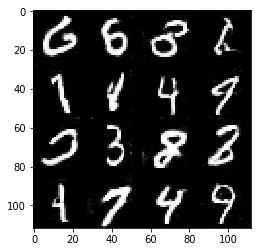

Generator Loss: 0.434 || Discriminator Loss: 1.465
Generator Loss: 0.281 || Discriminator Loss: 1.421
Generator Loss: 0.129 || Discriminator Loss: 1.665
Generator Loss: 0.179 || Discriminator Loss: 1.152
Generator Loss: 0.309 || Discriminator Loss: 0.663
Generator Loss: 0.677 || Discriminator Loss: 0.624
Generator Loss: 0.558 || Discriminator Loss: 0.735
Generator Loss: 0.493 || Discriminator Loss: 0.877
Generator Loss: 0.336 || Discriminator Loss: 0.863
Generator Loss: 0.320 || Discriminator Loss: 1.199


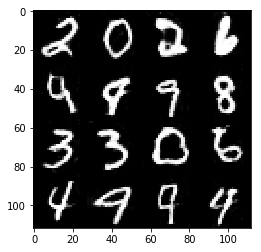

Generator Loss: 0.430 || Discriminator Loss: 0.801
Generator Loss: 0.298 || Discriminator Loss: 0.822
Generator Loss: 0.196 || Discriminator Loss: 1.187
Generator Loss: 0.619 || Discriminator Loss: 0.622
Generator Loss: 0.573 || Discriminator Loss: 0.889
Generator Loss: 0.338 || Discriminator Loss: 0.565
Generator Loss: 0.355 || Discriminator Loss: 0.469
Generator Loss: 0.521 || Discriminator Loss: 1.162
Generator Loss: 0.399 || Discriminator Loss: 1.052
Generator Loss: 0.413 || Discriminator Loss: 0.996


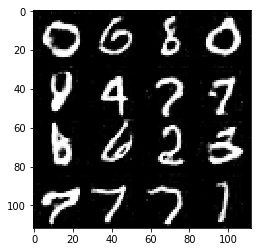

Generator Loss: 0.605 || Discriminator Loss: 0.987
Generator Loss: 0.423 || Discriminator Loss: 0.935
Generator Loss: 0.313 || Discriminator Loss: 1.008
Generator Loss: 0.387 || Discriminator Loss: 1.458
Generator Loss: 0.141 || Discriminator Loss: 1.216
Generator Loss: 0.416 || Discriminator Loss: 0.548
Generator Loss: 0.236 || Discriminator Loss: 1.392
Generator Loss: 0.363 || Discriminator Loss: 1.289
Generator Loss: 0.424 || Discriminator Loss: 0.391
Generator Loss: 0.360 || Discriminator Loss: 0.679


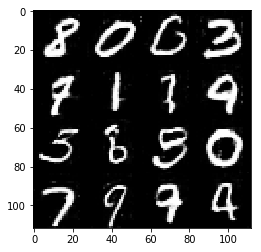

Generator Loss: 0.676 || Discriminator Loss: 0.616
Generator Loss: 0.212 || Discriminator Loss: 1.125
Generator Loss: 0.317 || Discriminator Loss: 0.811
Generator Loss: 0.672 || Discriminator Loss: 0.792
Generator Loss: 0.625 || Discriminator Loss: 0.728
Generator Loss: 0.494 || Discriminator Loss: 0.926
Generator Loss: 0.578 || Discriminator Loss: 1.065
Generator Loss: 0.368 || Discriminator Loss: 0.962
Generator Loss: 0.453 || Discriminator Loss: 1.003
Generator Loss: 0.456 || Discriminator Loss: 0.779


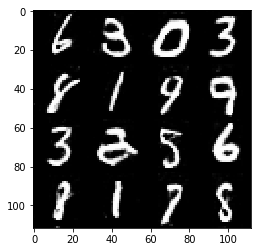

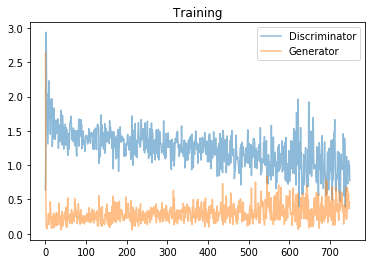

In [12]:
batch_size = 16
z_dim = 128
learning_rate = 0.0002
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Generator Loss: 1.164 || Discriminator Loss: 0.611
Generator Loss: 1.490 || Discriminator Loss: 1.473
Generator Loss: 0.078 || Discriminator Loss: 2.226
Generator Loss: 0.019 || Discriminator Loss: 3.308
Generator Loss: 0.250 || Discriminator Loss: 1.474
Generator Loss: 0.776 || Discriminator Loss: 0.953
Generator Loss: 1.391 || Discriminator Loss: 0.567
Generator Loss: 1.060 || Discriminator Loss: 1.404
Generator Loss: 1.394 || Discriminator Loss: 1.317
Generator Loss: 0.534 || Discriminator Loss: 1.189


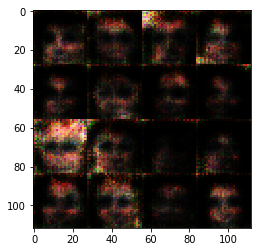

Generator Loss: 0.456 || Discriminator Loss: 0.960
Generator Loss: 0.119 || Discriminator Loss: 1.776
Generator Loss: 0.299 || Discriminator Loss: 1.207
Generator Loss: 0.145 || Discriminator Loss: 1.602
Generator Loss: 0.151 || Discriminator Loss: 1.587
Generator Loss: 0.706 || Discriminator Loss: 1.010
Generator Loss: 0.452 || Discriminator Loss: 0.967
Generator Loss: 0.190 || Discriminator Loss: 1.656
Generator Loss: 0.083 || Discriminator Loss: 2.164
Generator Loss: 0.081 || Discriminator Loss: 2.032


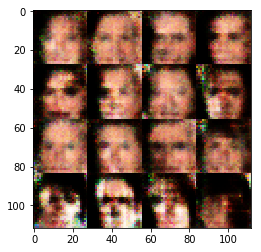

Generator Loss: 1.206 || Discriminator Loss: 0.898
Generator Loss: 1.416 || Discriminator Loss: 1.324
Generator Loss: 0.945 || Discriminator Loss: 1.108
Generator Loss: 0.207 || Discriminator Loss: 1.776
Generator Loss: 0.108 || Discriminator Loss: 1.865
Generator Loss: 0.562 || Discriminator Loss: 1.453
Generator Loss: 0.421 || Discriminator Loss: 1.367
Generator Loss: 0.140 || Discriminator Loss: 1.876
Generator Loss: 0.320 || Discriminator Loss: 1.118
Generator Loss: 0.174 || Discriminator Loss: 1.864


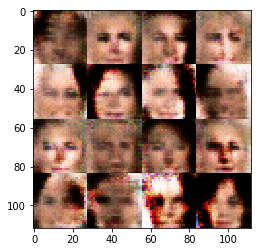

Generator Loss: 0.170 || Discriminator Loss: 1.684
Generator Loss: 0.521 || Discriminator Loss: 1.152
Generator Loss: 1.086 || Discriminator Loss: 1.377
Generator Loss: 0.465 || Discriminator Loss: 0.889
Generator Loss: 0.272 || Discriminator Loss: 1.629
Generator Loss: 0.254 || Discriminator Loss: 1.404
Generator Loss: 0.686 || Discriminator Loss: 1.410
Generator Loss: 0.975 || Discriminator Loss: 1.210
Generator Loss: 0.603 || Discriminator Loss: 1.008
Generator Loss: 0.699 || Discriminator Loss: 1.155


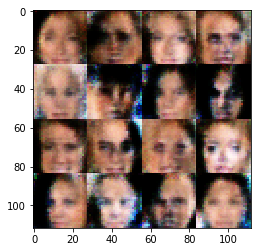

Generator Loss: 0.102 || Discriminator Loss: 1.777
Generator Loss: 0.693 || Discriminator Loss: 1.932
Generator Loss: 0.802 || Discriminator Loss: 1.432
Generator Loss: 0.378 || Discriminator Loss: 1.262
Generator Loss: 0.344 || Discriminator Loss: 1.294
Generator Loss: 0.660 || Discriminator Loss: 1.185
Generator Loss: 0.611 || Discriminator Loss: 1.453
Generator Loss: 0.893 || Discriminator Loss: 1.416
Generator Loss: 0.107 || Discriminator Loss: 1.948
Generator Loss: 0.178 || Discriminator Loss: 1.640


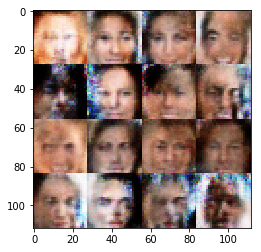

Generator Loss: 0.873 || Discriminator Loss: 0.836
Generator Loss: 0.919 || Discriminator Loss: 1.264
Generator Loss: 0.477 || Discriminator Loss: 1.197
Generator Loss: 0.580 || Discriminator Loss: 0.911
Generator Loss: 0.290 || Discriminator Loss: 1.484
Generator Loss: 0.259 || Discriminator Loss: 1.453
Generator Loss: 0.662 || Discriminator Loss: 1.250
Generator Loss: 0.506 || Discriminator Loss: 1.718
Generator Loss: 0.264 || Discriminator Loss: 1.261
Generator Loss: 0.976 || Discriminator Loss: 0.833


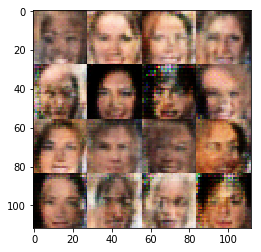

Generator Loss: 0.697 || Discriminator Loss: 1.095
Generator Loss: 0.144 || Discriminator Loss: 1.891
Generator Loss: 0.879 || Discriminator Loss: 0.897
Generator Loss: 0.595 || Discriminator Loss: 1.685
Generator Loss: 0.326 || Discriminator Loss: 1.224
Generator Loss: 0.160 || Discriminator Loss: 1.913
Generator Loss: 0.216 || Discriminator Loss: 1.618
Generator Loss: 0.352 || Discriminator Loss: 1.488
Generator Loss: 0.455 || Discriminator Loss: 1.270
Generator Loss: 0.307 || Discriminator Loss: 1.418


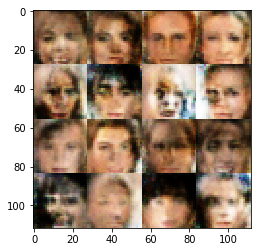

Generator Loss: 0.196 || Discriminator Loss: 1.624
Generator Loss: 0.352 || Discriminator Loss: 1.286
Generator Loss: 1.255 || Discriminator Loss: 1.849
Generator Loss: 0.952 || Discriminator Loss: 1.530
Generator Loss: 0.513 || Discriminator Loss: 1.441
Generator Loss: 0.193 || Discriminator Loss: 1.685
Generator Loss: 0.355 || Discriminator Loss: 1.461
Generator Loss: 0.374 || Discriminator Loss: 1.301
Generator Loss: 0.354 || Discriminator Loss: 1.314
Generator Loss: 0.680 || Discriminator Loss: 1.704


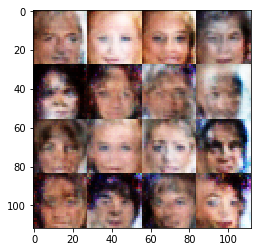

Generator Loss: 0.439 || Discriminator Loss: 1.202
Generator Loss: 0.411 || Discriminator Loss: 1.387
Generator Loss: 0.348 || Discriminator Loss: 1.399
Generator Loss: 0.340 || Discriminator Loss: 1.569
Generator Loss: 0.503 || Discriminator Loss: 1.352
Generator Loss: 0.373 || Discriminator Loss: 1.335
Generator Loss: 0.479 || Discriminator Loss: 1.358
Generator Loss: 0.257 || Discriminator Loss: 1.576
Generator Loss: 0.329 || Discriminator Loss: 1.406
Generator Loss: 0.455 || Discriminator Loss: 1.450


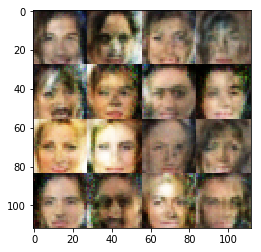

Generator Loss: 0.208 || Discriminator Loss: 1.645
Generator Loss: 0.490 || Discriminator Loss: 1.636
Generator Loss: 0.260 || Discriminator Loss: 1.437
Generator Loss: 0.540 || Discriminator Loss: 1.141
Generator Loss: 0.316 || Discriminator Loss: 1.374
Generator Loss: 0.957 || Discriminator Loss: 1.760
Generator Loss: 0.378 || Discriminator Loss: 1.554
Generator Loss: 0.492 || Discriminator Loss: 1.263
Generator Loss: 0.379 || Discriminator Loss: 1.386
Generator Loss: 0.429 || Discriminator Loss: 1.330


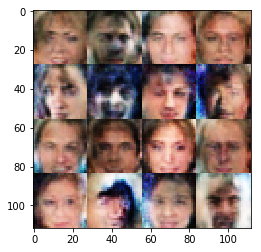

Generator Loss: 0.342 || Discriminator Loss: 1.426
Generator Loss: 0.246 || Discriminator Loss: 1.706
Generator Loss: 0.183 || Discriminator Loss: 1.793
Generator Loss: 0.399 || Discriminator Loss: 1.400
Generator Loss: 0.485 || Discriminator Loss: 1.554
Generator Loss: 0.351 || Discriminator Loss: 1.392
Generator Loss: 0.263 || Discriminator Loss: 1.406
Generator Loss: 0.436 || Discriminator Loss: 1.527
Generator Loss: 0.380 || Discriminator Loss: 1.635
Generator Loss: 0.381 || Discriminator Loss: 1.250


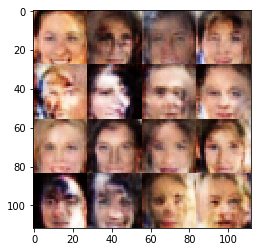

Generator Loss: 0.213 || Discriminator Loss: 1.573
Generator Loss: 0.304 || Discriminator Loss: 1.436
Generator Loss: 0.284 || Discriminator Loss: 1.530
Generator Loss: 0.305 || Discriminator Loss: 1.530
Generator Loss: 0.347 || Discriminator Loss: 1.385
Generator Loss: 0.304 || Discriminator Loss: 1.563
Generator Loss: 0.418 || Discriminator Loss: 1.508
Generator Loss: 0.374 || Discriminator Loss: 1.645
Generator Loss: 0.386 || Discriminator Loss: 1.453
Generator Loss: 0.457 || Discriminator Loss: 1.426


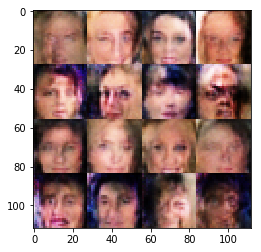

Generator Loss: 0.373 || Discriminator Loss: 1.495
Generator Loss: 0.351 || Discriminator Loss: 1.343
Generator Loss: 0.263 || Discriminator Loss: 1.795
Generator Loss: 0.266 || Discriminator Loss: 1.562
Generator Loss: 0.426 || Discriminator Loss: 1.470
Generator Loss: 0.371 || Discriminator Loss: 1.540
Generator Loss: 0.329 || Discriminator Loss: 1.485
Generator Loss: 0.378 || Discriminator Loss: 1.345
Generator Loss: 0.600 || Discriminator Loss: 1.364
Generator Loss: 0.231 || Discriminator Loss: 1.524


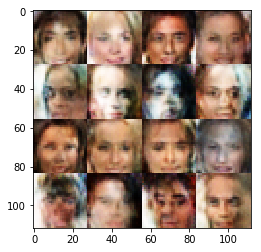

Generator Loss: 0.336 || Discriminator Loss: 1.392
Generator Loss: 0.348 || Discriminator Loss: 1.538
Generator Loss: 0.358 || Discriminator Loss: 1.507
Generator Loss: 0.447 || Discriminator Loss: 1.409
Generator Loss: 0.313 || Discriminator Loss: 1.355
Generator Loss: 0.311 || Discriminator Loss: 1.505
Generator Loss: 0.423 || Discriminator Loss: 1.372
Generator Loss: 0.312 || Discriminator Loss: 1.557
Generator Loss: 0.259 || Discriminator Loss: 1.403
Generator Loss: 0.239 || Discriminator Loss: 1.676


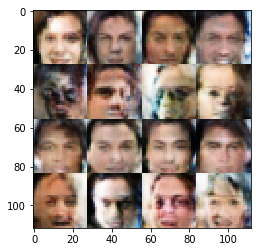

Generator Loss: 0.255 || Discriminator Loss: 1.570
Generator Loss: 0.315 || Discriminator Loss: 1.422
Generator Loss: 0.270 || Discriminator Loss: 1.581
Generator Loss: 0.381 || Discriminator Loss: 1.421
Generator Loss: 0.348 || Discriminator Loss: 1.408
Generator Loss: 0.344 || Discriminator Loss: 1.274
Generator Loss: 0.423 || Discriminator Loss: 1.469
Generator Loss: 0.334 || Discriminator Loss: 1.412
Generator Loss: 0.377 || Discriminator Loss: 1.377
Generator Loss: 0.362 || Discriminator Loss: 1.440


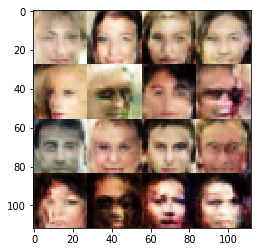

Generator Loss: 0.288 || Discriminator Loss: 1.647
Generator Loss: 0.388 || Discriminator Loss: 1.499
Generator Loss: 0.338 || Discriminator Loss: 1.436
Generator Loss: 0.315 || Discriminator Loss: 1.507
Generator Loss: 0.370 || Discriminator Loss: 1.469
Generator Loss: 0.296 || Discriminator Loss: 1.454
Generator Loss: 0.375 || Discriminator Loss: 1.371
Generator Loss: 0.392 || Discriminator Loss: 1.371
Generator Loss: 0.390 || Discriminator Loss: 1.424
Generator Loss: 0.305 || Discriminator Loss: 1.410


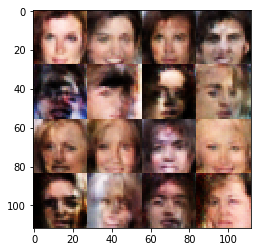

Generator Loss: 0.238 || Discriminator Loss: 1.583
Generator Loss: 0.404 || Discriminator Loss: 1.536
Generator Loss: 0.260 || Discriminator Loss: 1.663
Generator Loss: 0.496 || Discriminator Loss: 1.519
Generator Loss: 0.381 || Discriminator Loss: 1.447
Generator Loss: 0.358 || Discriminator Loss: 1.414
Generator Loss: 0.380 || Discriminator Loss: 1.433
Generator Loss: 0.343 || Discriminator Loss: 1.432
Generator Loss: 0.468 || Discriminator Loss: 1.392
Generator Loss: 0.306 || Discriminator Loss: 1.461


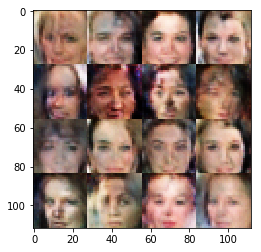

Generator Loss: 0.285 || Discriminator Loss: 1.606
Generator Loss: 0.408 || Discriminator Loss: 1.543
Generator Loss: 0.329 || Discriminator Loss: 1.515
Generator Loss: 0.359 || Discriminator Loss: 1.364
Generator Loss: 0.387 || Discriminator Loss: 1.576
Generator Loss: 0.502 || Discriminator Loss: 1.317
Generator Loss: 0.376 || Discriminator Loss: 1.403
Generator Loss: 0.459 || Discriminator Loss: 1.440
Generator Loss: 0.394 || Discriminator Loss: 1.460
Generator Loss: 0.336 || Discriminator Loss: 1.451


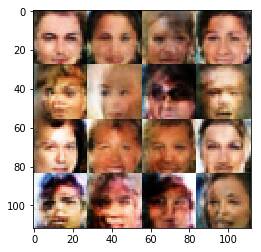

Generator Loss: 0.341 || Discriminator Loss: 1.437
Generator Loss: 0.375 || Discriminator Loss: 1.232
Generator Loss: 0.261 || Discriminator Loss: 1.503
Generator Loss: 0.351 || Discriminator Loss: 1.521
Generator Loss: 0.398 || Discriminator Loss: 1.437
Generator Loss: 0.340 || Discriminator Loss: 1.393
Generator Loss: 0.400 || Discriminator Loss: 1.447
Generator Loss: 0.337 || Discriminator Loss: 1.550
Generator Loss: 0.504 || Discriminator Loss: 1.296
Generator Loss: 0.399 || Discriminator Loss: 1.405


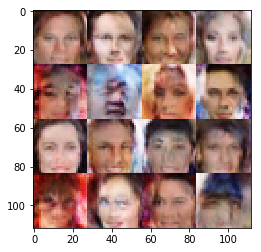

Generator Loss: 0.329 || Discriminator Loss: 1.418
Generator Loss: 0.367 || Discriminator Loss: 1.526
Generator Loss: 0.377 || Discriminator Loss: 1.590
Generator Loss: 0.426 || Discriminator Loss: 1.487
Generator Loss: 0.346 || Discriminator Loss: 1.410
Generator Loss: 0.356 || Discriminator Loss: 1.491
Generator Loss: 0.389 || Discriminator Loss: 1.441
Generator Loss: 0.379 || Discriminator Loss: 1.469
Generator Loss: 0.288 || Discriminator Loss: 1.463
Generator Loss: 0.408 || Discriminator Loss: 1.418


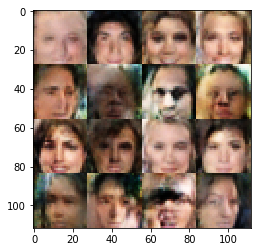

Generator Loss: 0.336 || Discriminator Loss: 1.494
Generator Loss: 0.270 || Discriminator Loss: 1.653
Generator Loss: 0.456 || Discriminator Loss: 1.398
Generator Loss: 0.281 || Discriminator Loss: 1.544
Generator Loss: 0.344 || Discriminator Loss: 1.570
Generator Loss: 0.369 || Discriminator Loss: 1.329
Generator Loss: 0.453 || Discriminator Loss: 1.298
Generator Loss: 0.325 || Discriminator Loss: 1.469
Generator Loss: 0.368 || Discriminator Loss: 1.602
Generator Loss: 0.326 || Discriminator Loss: 1.389


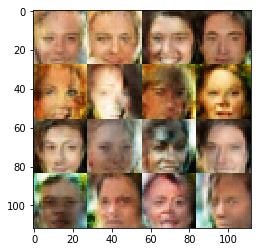

Generator Loss: 0.418 || Discriminator Loss: 1.426
Generator Loss: 0.442 || Discriminator Loss: 1.385
Generator Loss: 0.295 || Discriminator Loss: 1.442
Generator Loss: 0.408 || Discriminator Loss: 1.500
Generator Loss: 0.348 || Discriminator Loss: 1.456
Generator Loss: 0.431 || Discriminator Loss: 1.355
Generator Loss: 0.398 || Discriminator Loss: 1.498
Generator Loss: 0.336 || Discriminator Loss: 1.359
Generator Loss: 0.387 || Discriminator Loss: 1.470
Generator Loss: 0.325 || Discriminator Loss: 1.553


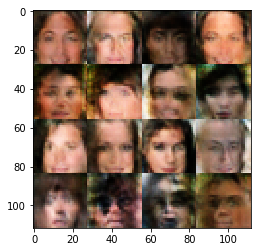

Generator Loss: 0.427 || Discriminator Loss: 1.411
Generator Loss: 0.388 || Discriminator Loss: 1.442
Generator Loss: 0.563 || Discriminator Loss: 1.448
Generator Loss: 0.403 || Discriminator Loss: 1.415
Generator Loss: 0.365 || Discriminator Loss: 1.509
Generator Loss: 0.297 || Discriminator Loss: 1.598
Generator Loss: 0.357 || Discriminator Loss: 1.442
Generator Loss: 0.337 || Discriminator Loss: 1.366
Generator Loss: 0.337 || Discriminator Loss: 1.538
Generator Loss: 0.406 || Discriminator Loss: 1.470


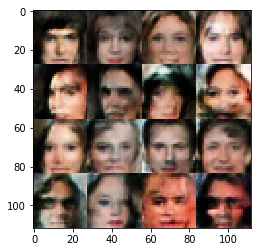

Generator Loss: 0.276 || Discriminator Loss: 1.501
Generator Loss: 0.339 || Discriminator Loss: 1.576
Generator Loss: 0.420 || Discriminator Loss: 1.490
Generator Loss: 0.441 || Discriminator Loss: 1.400
Generator Loss: 0.396 || Discriminator Loss: 1.372
Generator Loss: 0.457 || Discriminator Loss: 1.578
Generator Loss: 0.464 || Discriminator Loss: 1.358
Generator Loss: 0.414 || Discriminator Loss: 1.467
Generator Loss: 0.395 || Discriminator Loss: 1.384
Generator Loss: 0.308 || Discriminator Loss: 1.550


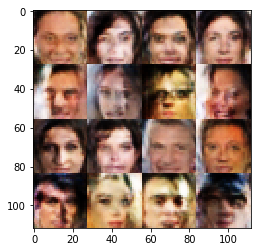

Generator Loss: 0.357 || Discriminator Loss: 1.479
Generator Loss: 0.384 || Discriminator Loss: 1.433
Generator Loss: 0.420 || Discriminator Loss: 1.437
Generator Loss: 0.423 || Discriminator Loss: 1.350
Generator Loss: 0.324 || Discriminator Loss: 1.591
Generator Loss: 0.370 || Discriminator Loss: 1.488
Generator Loss: 0.316 || Discriminator Loss: 1.573
Generator Loss: 0.398 || Discriminator Loss: 1.608
Generator Loss: 0.375 || Discriminator Loss: 1.414
Generator Loss: 0.420 || Discriminator Loss: 1.337


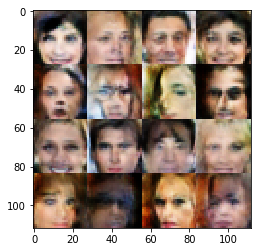

Generator Loss: 0.447 || Discriminator Loss: 1.452
Generator Loss: 0.431 || Discriminator Loss: 1.418
Generator Loss: 0.387 || Discriminator Loss: 1.328
Generator Loss: 0.310 || Discriminator Loss: 1.436
Generator Loss: 0.452 || Discriminator Loss: 1.365
Generator Loss: 0.316 || Discriminator Loss: 1.527
Generator Loss: 0.419 || Discriminator Loss: 1.496
Generator Loss: 0.422 || Discriminator Loss: 1.450
Generator Loss: 0.517 || Discriminator Loss: 1.316
Generator Loss: 0.350 || Discriminator Loss: 1.577


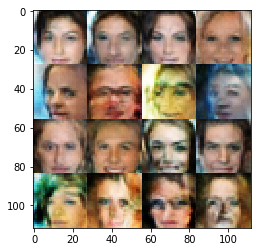

Generator Loss: 0.288 || Discriminator Loss: 1.507
Generator Loss: 0.368 || Discriminator Loss: 1.372
Generator Loss: 0.330 || Discriminator Loss: 1.428
Generator Loss: 0.490 || Discriminator Loss: 1.436
Generator Loss: 0.329 || Discriminator Loss: 1.431
Generator Loss: 0.291 || Discriminator Loss: 1.644
Generator Loss: 0.283 || Discriminator Loss: 1.372
Generator Loss: 0.374 || Discriminator Loss: 1.562
Generator Loss: 0.400 || Discriminator Loss: 1.446
Generator Loss: 0.347 || Discriminator Loss: 1.406


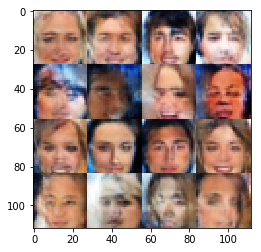

Generator Loss: 0.331 || Discriminator Loss: 1.508
Generator Loss: 0.370 || Discriminator Loss: 1.478
Generator Loss: 0.368 || Discriminator Loss: 1.429
Generator Loss: 0.322 || Discriminator Loss: 1.475
Generator Loss: 0.365 || Discriminator Loss: 1.476
Generator Loss: 0.457 || Discriminator Loss: 1.336
Generator Loss: 0.445 || Discriminator Loss: 1.458
Generator Loss: 0.351 || Discriminator Loss: 1.546
Generator Loss: 0.428 || Discriminator Loss: 1.476
Generator Loss: 0.385 || Discriminator Loss: 1.492


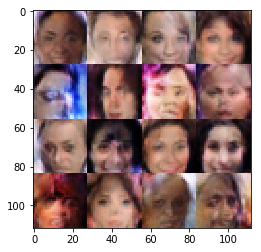

Generator Loss: 0.359 || Discriminator Loss: 1.486
Generator Loss: 0.405 || Discriminator Loss: 1.476
Generator Loss: 0.358 || Discriminator Loss: 1.502
Generator Loss: 0.295 || Discriminator Loss: 1.465
Generator Loss: 0.294 || Discriminator Loss: 1.442
Generator Loss: 0.383 || Discriminator Loss: 1.512
Generator Loss: 0.385 || Discriminator Loss: 1.389
Generator Loss: 0.361 || Discriminator Loss: 1.550
Generator Loss: 0.457 || Discriminator Loss: 1.392
Generator Loss: 0.290 || Discriminator Loss: 1.461


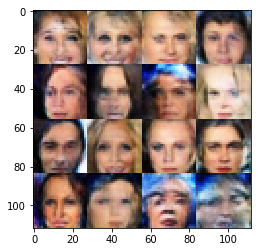

Generator Loss: 0.435 || Discriminator Loss: 1.289
Generator Loss: 0.333 || Discriminator Loss: 1.584
Generator Loss: 0.463 || Discriminator Loss: 1.390
Generator Loss: 0.327 || Discriminator Loss: 1.492
Generator Loss: 0.426 || Discriminator Loss: 1.404
Generator Loss: 0.420 || Discriminator Loss: 1.314
Generator Loss: 0.327 || Discriminator Loss: 1.558
Generator Loss: 0.354 || Discriminator Loss: 1.474
Generator Loss: 0.415 || Discriminator Loss: 1.553
Generator Loss: 0.456 || Discriminator Loss: 1.396


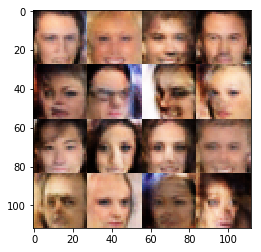

Generator Loss: 0.312 || Discriminator Loss: 1.496
Generator Loss: 0.455 || Discriminator Loss: 1.416
Generator Loss: 0.360 || Discriminator Loss: 1.571
Generator Loss: 0.449 || Discriminator Loss: 1.348
Generator Loss: 0.337 || Discriminator Loss: 1.486
Generator Loss: 0.421 || Discriminator Loss: 1.465
Generator Loss: 0.382 || Discriminator Loss: 1.447
Generator Loss: 0.399 || Discriminator Loss: 1.500
Generator Loss: 0.377 || Discriminator Loss: 1.451
Generator Loss: 0.403 || Discriminator Loss: 1.467


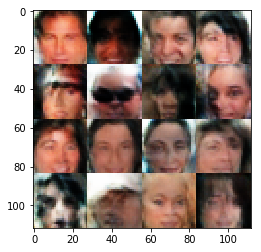

Generator Loss: 0.455 || Discriminator Loss: 1.378
Generator Loss: 0.366 || Discriminator Loss: 1.526
Generator Loss: 0.405 || Discriminator Loss: 1.434
Generator Loss: 0.321 || Discriminator Loss: 1.510
Generator Loss: 0.376 || Discriminator Loss: 1.405
Generator Loss: 0.336 || Discriminator Loss: 1.527
Generator Loss: 0.376 || Discriminator Loss: 1.464
Generator Loss: 0.416 || Discriminator Loss: 1.425
Generator Loss: 0.290 || Discriminator Loss: 1.515
Generator Loss: 0.456 || Discriminator Loss: 1.463


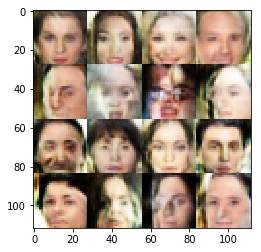

Generator Loss: 0.462 || Discriminator Loss: 1.462
Generator Loss: 0.416 || Discriminator Loss: 1.458
Generator Loss: 0.380 || Discriminator Loss: 1.407
Generator Loss: 0.480 || Discriminator Loss: 1.500
Generator Loss: 0.404 || Discriminator Loss: 1.438
Generator Loss: 0.510 || Discriminator Loss: 1.488
Generator Loss: 0.430 || Discriminator Loss: 1.590
Generator Loss: 0.432 || Discriminator Loss: 1.454
Generator Loss: 0.434 || Discriminator Loss: 1.416
Generator Loss: 0.383 || Discriminator Loss: 1.311


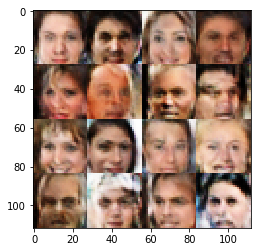

Generator Loss: 0.362 || Discriminator Loss: 1.443
Generator Loss: 0.469 || Discriminator Loss: 1.342
Generator Loss: 0.391 || Discriminator Loss: 1.400
Generator Loss: 0.423 || Discriminator Loss: 1.439
Generator Loss: 0.418 || Discriminator Loss: 1.346
Generator Loss: 0.423 || Discriminator Loss: 1.488
Generator Loss: 0.368 || Discriminator Loss: 1.444
Generator Loss: 0.313 || Discriminator Loss: 1.516
Generator Loss: 0.331 || Discriminator Loss: 1.526
Generator Loss: 0.374 || Discriminator Loss: 1.380


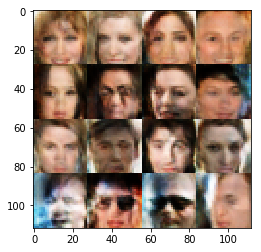

Generator Loss: 0.429 || Discriminator Loss: 1.394
Generator Loss: 0.353 || Discriminator Loss: 1.459
Generator Loss: 0.363 || Discriminator Loss: 1.505
Generator Loss: 0.397 || Discriminator Loss: 1.438
Generator Loss: 0.460 || Discriminator Loss: 1.370
Generator Loss: 0.396 || Discriminator Loss: 1.386
Generator Loss: 0.452 || Discriminator Loss: 1.470
Generator Loss: 0.365 || Discriminator Loss: 1.619
Generator Loss: 0.459 || Discriminator Loss: 1.437
Generator Loss: 0.451 || Discriminator Loss: 1.322


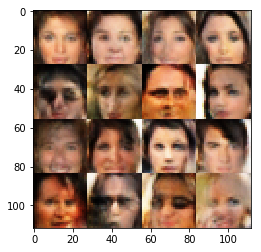

Generator Loss: 0.369 || Discriminator Loss: 1.480
Generator Loss: 0.417 || Discriminator Loss: 1.380
Generator Loss: 0.302 || Discriminator Loss: 1.577
Generator Loss: 0.289 || Discriminator Loss: 1.618
Generator Loss: 0.438 || Discriminator Loss: 1.376
Generator Loss: 0.422 || Discriminator Loss: 1.516
Generator Loss: 0.416 || Discriminator Loss: 1.304
Generator Loss: 0.381 || Discriminator Loss: 1.383
Generator Loss: 0.389 || Discriminator Loss: 1.538
Generator Loss: 0.404 || Discriminator Loss: 1.519


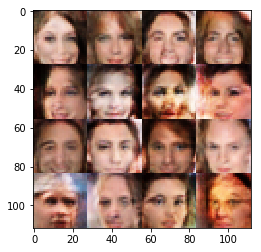

Generator Loss: 0.280 || Discriminator Loss: 1.551
Generator Loss: 0.417 || Discriminator Loss: 1.418
Generator Loss: 0.404 || Discriminator Loss: 1.437
Generator Loss: 0.397 || Discriminator Loss: 1.508
Generator Loss: 0.390 || Discriminator Loss: 1.421
Generator Loss: 0.346 || Discriminator Loss: 1.517
Generator Loss: 0.427 || Discriminator Loss: 1.477
Generator Loss: 0.394 || Discriminator Loss: 1.470
Generator Loss: 0.445 || Discriminator Loss: 1.444
Generator Loss: 0.396 || Discriminator Loss: 1.557


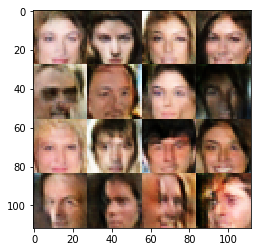

Generator Loss: 0.410 || Discriminator Loss: 1.552
Generator Loss: 0.303 || Discriminator Loss: 1.509
Generator Loss: 0.441 || Discriminator Loss: 1.386
Generator Loss: 0.409 || Discriminator Loss: 1.533
Generator Loss: 0.474 || Discriminator Loss: 1.383
Generator Loss: 0.356 || Discriminator Loss: 1.491
Generator Loss: 0.379 || Discriminator Loss: 1.426
Generator Loss: 0.407 || Discriminator Loss: 1.456
Generator Loss: 0.410 || Discriminator Loss: 1.525
Generator Loss: 0.359 || Discriminator Loss: 1.468


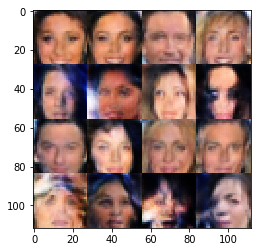

Generator Loss: 0.385 || Discriminator Loss: 1.441
Generator Loss: 0.390 || Discriminator Loss: 1.354
Generator Loss: 0.451 || Discriminator Loss: 1.418
Generator Loss: 0.399 || Discriminator Loss: 1.439
Generator Loss: 0.417 || Discriminator Loss: 1.387
Generator Loss: 0.385 || Discriminator Loss: 1.503
Generator Loss: 0.460 || Discriminator Loss: 1.313
Generator Loss: 0.420 || Discriminator Loss: 1.454
Generator Loss: 0.316 || Discriminator Loss: 1.505
Generator Loss: 0.423 || Discriminator Loss: 1.426


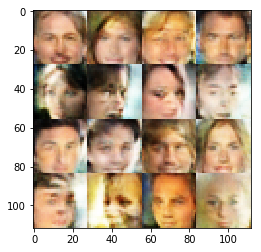

Generator Loss: 0.312 || Discriminator Loss: 1.513
Generator Loss: 0.391 || Discriminator Loss: 1.462
Generator Loss: 0.377 || Discriminator Loss: 1.440
Generator Loss: 0.429 || Discriminator Loss: 1.383
Generator Loss: 0.474 || Discriminator Loss: 1.375
Generator Loss: 0.440 || Discriminator Loss: 1.408
Generator Loss: 0.392 || Discriminator Loss: 1.450
Generator Loss: 0.439 || Discriminator Loss: 1.396
Generator Loss: 0.432 || Discriminator Loss: 1.301
Generator Loss: 0.335 || Discriminator Loss: 1.431


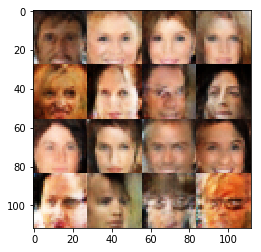

Generator Loss: 0.409 || Discriminator Loss: 1.407
Generator Loss: 0.522 || Discriminator Loss: 1.366
Generator Loss: 0.467 || Discriminator Loss: 1.368
Generator Loss: 0.413 || Discriminator Loss: 1.341
Generator Loss: 0.487 || Discriminator Loss: 1.363
Generator Loss: 0.442 || Discriminator Loss: 1.442
Generator Loss: 0.557 || Discriminator Loss: 1.402
Generator Loss: 0.494 || Discriminator Loss: 1.399
Generator Loss: 0.383 || Discriminator Loss: 1.464
Generator Loss: 0.399 || Discriminator Loss: 1.358


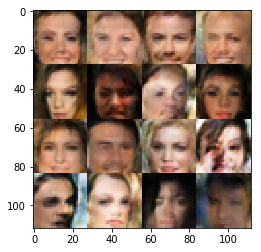

Generator Loss: 0.474 || Discriminator Loss: 1.326
Generator Loss: 0.431 || Discriminator Loss: 1.421
Generator Loss: 0.380 || Discriminator Loss: 1.440
Generator Loss: 0.443 || Discriminator Loss: 1.381
Generator Loss: 0.414 || Discriminator Loss: 1.502
Generator Loss: 0.373 || Discriminator Loss: 1.443
Generator Loss: 0.418 || Discriminator Loss: 1.421
Generator Loss: 0.428 || Discriminator Loss: 1.487
Generator Loss: 0.499 || Discriminator Loss: 1.444
Generator Loss: 0.423 || Discriminator Loss: 1.436


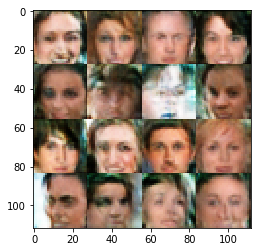

Generator Loss: 0.387 || Discriminator Loss: 1.458
Generator Loss: 0.372 || Discriminator Loss: 1.490
Generator Loss: 0.449 || Discriminator Loss: 1.390
Generator Loss: 0.413 || Discriminator Loss: 1.450
Generator Loss: 0.391 || Discriminator Loss: 1.450
Generator Loss: 0.388 || Discriminator Loss: 1.363
Generator Loss: 0.367 || Discriminator Loss: 1.428
Generator Loss: 0.383 || Discriminator Loss: 1.433
Generator Loss: 0.454 || Discriminator Loss: 1.450
Generator Loss: 0.617 || Discriminator Loss: 1.355


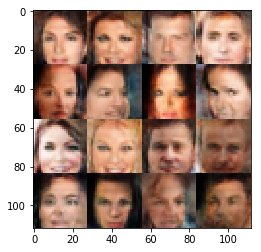

Generator Loss: 0.376 || Discriminator Loss: 1.428
Generator Loss: 0.403 || Discriminator Loss: 1.426
Generator Loss: 0.475 || Discriminator Loss: 1.407
Generator Loss: 0.596 || Discriminator Loss: 1.283
Generator Loss: 0.424 || Discriminator Loss: 1.415
Generator Loss: 0.452 || Discriminator Loss: 1.359
Generator Loss: 0.372 || Discriminator Loss: 1.474
Generator Loss: 0.508 || Discriminator Loss: 1.370
Generator Loss: 0.445 || Discriminator Loss: 1.317
Generator Loss: 0.442 || Discriminator Loss: 1.434


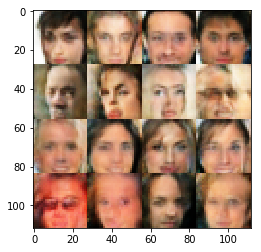

Generator Loss: 0.510 || Discriminator Loss: 1.361
Generator Loss: 0.334 || Discriminator Loss: 1.533
Generator Loss: 0.461 || Discriminator Loss: 1.409
Generator Loss: 0.357 || Discriminator Loss: 1.391
Generator Loss: 0.315 || Discriminator Loss: 1.482
Generator Loss: 0.452 || Discriminator Loss: 1.446
Generator Loss: 0.429 || Discriminator Loss: 1.450
Generator Loss: 0.441 || Discriminator Loss: 1.385
Generator Loss: 0.388 || Discriminator Loss: 1.404
Generator Loss: 0.456 || Discriminator Loss: 1.387


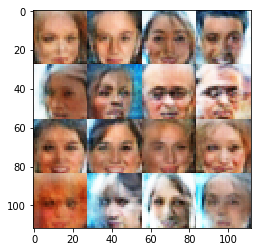

Generator Loss: 0.445 || Discriminator Loss: 1.328
Generator Loss: 0.441 || Discriminator Loss: 1.352
Generator Loss: 0.488 || Discriminator Loss: 1.326
Generator Loss: 0.385 || Discriminator Loss: 1.504
Generator Loss: 0.383 || Discriminator Loss: 1.431
Generator Loss: 0.422 || Discriminator Loss: 1.414
Generator Loss: 0.443 || Discriminator Loss: 1.408
Generator Loss: 0.338 || Discriminator Loss: 1.500
Generator Loss: 0.490 || Discriminator Loss: 1.438
Generator Loss: 0.344 || Discriminator Loss: 1.454


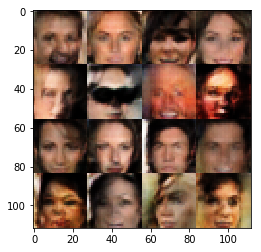

Generator Loss: 0.415 || Discriminator Loss: 1.429
Generator Loss: 0.398 || Discriminator Loss: 1.515
Generator Loss: 0.418 || Discriminator Loss: 1.356
Generator Loss: 0.437 || Discriminator Loss: 1.419
Generator Loss: 0.318 || Discriminator Loss: 1.438
Generator Loss: 0.399 || Discriminator Loss: 1.484
Generator Loss: 0.369 || Discriminator Loss: 1.355
Generator Loss: 0.414 || Discriminator Loss: 1.451
Generator Loss: 0.485 || Discriminator Loss: 1.454
Generator Loss: 0.400 || Discriminator Loss: 1.337


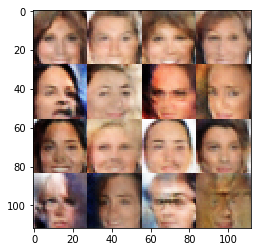

Generator Loss: 0.377 || Discriminator Loss: 1.415
Generator Loss: 0.419 || Discriminator Loss: 1.445
Generator Loss: 0.542 || Discriminator Loss: 1.424
Generator Loss: 0.379 || Discriminator Loss: 1.486
Generator Loss: 0.466 || Discriminator Loss: 1.370
Generator Loss: 0.453 || Discriminator Loss: 1.413
Generator Loss: 0.422 || Discriminator Loss: 1.419
Generator Loss: 0.420 || Discriminator Loss: 1.430
Generator Loss: 0.378 || Discriminator Loss: 1.440
Generator Loss: 0.430 || Discriminator Loss: 1.474


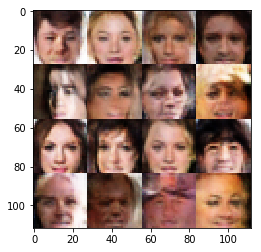

Generator Loss: 0.383 || Discriminator Loss: 1.428
Generator Loss: 0.415 || Discriminator Loss: 1.489
Generator Loss: 0.361 || Discriminator Loss: 1.452
Generator Loss: 0.429 || Discriminator Loss: 1.457
Generator Loss: 0.461 || Discriminator Loss: 1.440
Generator Loss: 0.433 || Discriminator Loss: 1.390
Generator Loss: 0.369 || Discriminator Loss: 1.390
Generator Loss: 0.391 || Discriminator Loss: 1.408
Generator Loss: 0.448 || Discriminator Loss: 1.374
Generator Loss: 0.425 || Discriminator Loss: 1.380


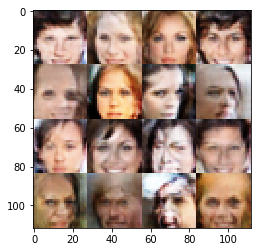

Generator Loss: 0.396 || Discriminator Loss: 1.448
Generator Loss: 0.459 || Discriminator Loss: 1.336
Generator Loss: 0.489 || Discriminator Loss: 1.351
Generator Loss: 0.406 || Discriminator Loss: 1.489
Generator Loss: 0.457 || Discriminator Loss: 1.413
Generator Loss: 0.465 || Discriminator Loss: 1.480
Generator Loss: 0.437 || Discriminator Loss: 1.358
Generator Loss: 0.446 || Discriminator Loss: 1.294
Generator Loss: 0.453 || Discriminator Loss: 1.328
Generator Loss: 0.533 || Discriminator Loss: 1.430


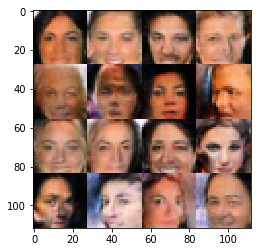

Generator Loss: 0.462 || Discriminator Loss: 1.422
Generator Loss: 0.519 || Discriminator Loss: 1.358
Generator Loss: 0.424 || Discriminator Loss: 1.389
Generator Loss: 0.516 || Discriminator Loss: 1.379
Generator Loss: 0.469 || Discriminator Loss: 1.379
Generator Loss: 0.404 || Discriminator Loss: 1.449
Generator Loss: 0.411 || Discriminator Loss: 1.384
Generator Loss: 0.394 || Discriminator Loss: 1.399
Generator Loss: 0.492 || Discriminator Loss: 1.357
Generator Loss: 0.435 || Discriminator Loss: 1.392


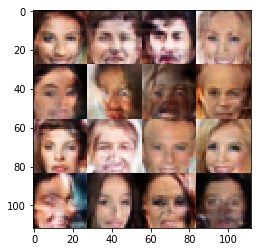

Generator Loss: 0.405 || Discriminator Loss: 1.377
Generator Loss: 0.434 || Discriminator Loss: 1.439
Generator Loss: 0.370 || Discriminator Loss: 1.429
Generator Loss: 0.432 || Discriminator Loss: 1.409
Generator Loss: 0.455 || Discriminator Loss: 1.396
Generator Loss: 0.434 || Discriminator Loss: 1.389
Generator Loss: 0.397 || Discriminator Loss: 1.503
Generator Loss: 0.516 || Discriminator Loss: 1.430
Generator Loss: 0.591 || Discriminator Loss: 1.313
Generator Loss: 0.407 || Discriminator Loss: 1.407


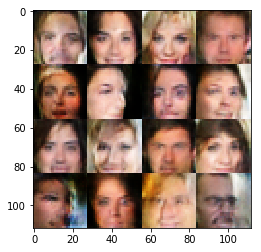

Generator Loss: 0.473 || Discriminator Loss: 1.347
Generator Loss: 0.353 || Discriminator Loss: 1.416
Generator Loss: 0.464 || Discriminator Loss: 1.408
Generator Loss: 0.465 || Discriminator Loss: 1.384
Generator Loss: 0.447 || Discriminator Loss: 1.437
Generator Loss: 0.368 || Discriminator Loss: 1.377
Generator Loss: 0.474 || Discriminator Loss: 1.405
Generator Loss: 0.510 || Discriminator Loss: 1.347
Generator Loss: 0.386 || Discriminator Loss: 1.414
Generator Loss: 0.352 || Discriminator Loss: 1.497


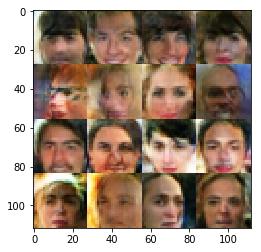

Generator Loss: 0.479 || Discriminator Loss: 1.410
Generator Loss: 0.516 || Discriminator Loss: 1.329
Generator Loss: 0.484 || Discriminator Loss: 1.418
Generator Loss: 0.415 || Discriminator Loss: 1.421
Generator Loss: 0.416 || Discriminator Loss: 1.352
Generator Loss: 0.443 || Discriminator Loss: 1.319
Generator Loss: 0.401 || Discriminator Loss: 1.480
Generator Loss: 0.452 || Discriminator Loss: 1.368
Generator Loss: 0.475 || Discriminator Loss: 1.406
Generator Loss: 0.443 || Discriminator Loss: 1.408


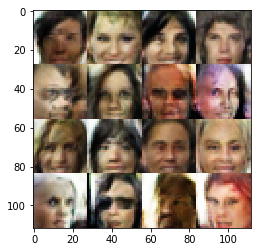

Generator Loss: 0.508 || Discriminator Loss: 1.341
Generator Loss: 0.430 || Discriminator Loss: 1.408
Generator Loss: 0.393 || Discriminator Loss: 1.402
Generator Loss: 0.530 || Discriminator Loss: 1.400
Generator Loss: 0.375 || Discriminator Loss: 1.452
Generator Loss: 0.399 || Discriminator Loss: 1.444
Generator Loss: 0.474 || Discriminator Loss: 1.338
Generator Loss: 0.458 || Discriminator Loss: 1.430
Generator Loss: 0.417 || Discriminator Loss: 1.366
Generator Loss: 0.471 || Discriminator Loss: 1.388


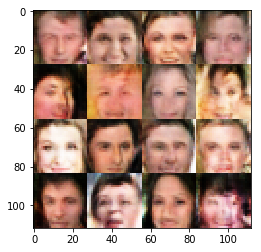

Generator Loss: 0.473 || Discriminator Loss: 1.361
Generator Loss: 0.395 || Discriminator Loss: 1.456
Generator Loss: 0.424 || Discriminator Loss: 1.246
Generator Loss: 0.492 || Discriminator Loss: 1.406
Generator Loss: 0.428 || Discriminator Loss: 1.370
Generator Loss: 0.423 || Discriminator Loss: 1.406
Generator Loss: 0.360 || Discriminator Loss: 1.373
Generator Loss: 0.455 || Discriminator Loss: 1.387
Generator Loss: 0.480 || Discriminator Loss: 1.370
Generator Loss: 0.370 || Discriminator Loss: 1.474


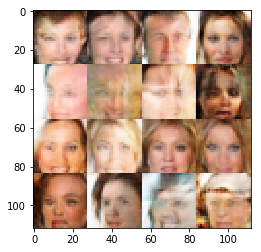

Generator Loss: 0.537 || Discriminator Loss: 1.336
Generator Loss: 0.348 || Discriminator Loss: 1.476
Generator Loss: 0.422 || Discriminator Loss: 1.421
Generator Loss: 0.406 || Discriminator Loss: 1.362
Generator Loss: 0.521 || Discriminator Loss: 1.334
Generator Loss: 0.370 || Discriminator Loss: 1.451
Generator Loss: 0.480 || Discriminator Loss: 1.293
Generator Loss: 0.510 || Discriminator Loss: 1.482
Generator Loss: 0.476 || Discriminator Loss: 1.346
Generator Loss: 0.375 || Discriminator Loss: 1.390


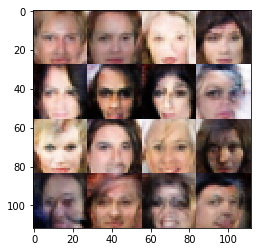

Generator Loss: 0.397 || Discriminator Loss: 1.429
Generator Loss: 0.491 || Discriminator Loss: 1.384
Generator Loss: 0.475 || Discriminator Loss: 1.407
Generator Loss: 0.420 || Discriminator Loss: 1.336
Generator Loss: 0.399 || Discriminator Loss: 1.441
Generator Loss: 0.448 || Discriminator Loss: 1.383
Generator Loss: 0.521 || Discriminator Loss: 1.338
Generator Loss: 0.379 || Discriminator Loss: 1.503
Generator Loss: 0.418 || Discriminator Loss: 1.445
Generator Loss: 0.382 || Discriminator Loss: 1.466


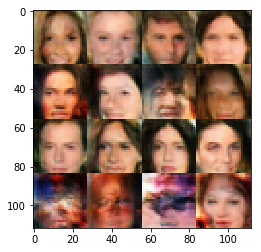

Generator Loss: 0.435 || Discriminator Loss: 1.417
Generator Loss: 0.432 || Discriminator Loss: 1.440
Generator Loss: 0.449 || Discriminator Loss: 1.370
Generator Loss: 0.469 || Discriminator Loss: 1.382
Generator Loss: 0.425 || Discriminator Loss: 1.472
Generator Loss: 0.444 || Discriminator Loss: 1.356
Generator Loss: 0.605 || Discriminator Loss: 1.407
Generator Loss: 0.404 || Discriminator Loss: 1.403
Generator Loss: 0.470 || Discriminator Loss: 1.385
Generator Loss: 0.419 || Discriminator Loss: 1.514


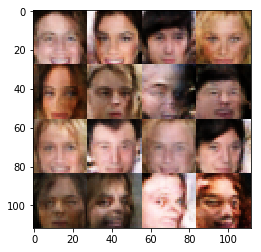

Generator Loss: 0.495 || Discriminator Loss: 1.422
Generator Loss: 0.468 || Discriminator Loss: 1.311
Generator Loss: 0.463 || Discriminator Loss: 1.402
Generator Loss: 0.405 || Discriminator Loss: 1.471
Generator Loss: 0.437 || Discriminator Loss: 1.355
Generator Loss: 0.403 || Discriminator Loss: 1.353
Generator Loss: 0.512 || Discriminator Loss: 1.405
Generator Loss: 0.377 || Discriminator Loss: 1.395
Generator Loss: 0.426 || Discriminator Loss: 1.435
Generator Loss: 0.411 || Discriminator Loss: 1.398


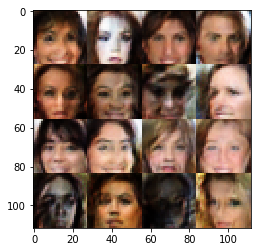

Generator Loss: 0.463 || Discriminator Loss: 1.419
Generator Loss: 0.411 || Discriminator Loss: 1.423
Generator Loss: 0.517 || Discriminator Loss: 1.356
Generator Loss: 0.510 || Discriminator Loss: 1.302
Generator Loss: 0.454 || Discriminator Loss: 1.399
Generator Loss: 0.524 || Discriminator Loss: 1.305
Generator Loss: 0.411 || Discriminator Loss: 1.473
Generator Loss: 0.386 || Discriminator Loss: 1.407
Generator Loss: 0.452 || Discriminator Loss: 1.424
Generator Loss: 0.512 || Discriminator Loss: 1.383


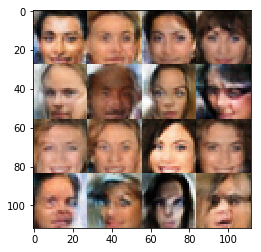

Generator Loss: 0.463 || Discriminator Loss: 1.371
Generator Loss: 0.601 || Discriminator Loss: 1.339
Generator Loss: 0.352 || Discriminator Loss: 1.427
Generator Loss: 0.374 || Discriminator Loss: 1.439
Generator Loss: 0.527 || Discriminator Loss: 1.379
Generator Loss: 0.407 || Discriminator Loss: 1.424
Generator Loss: 0.500 || Discriminator Loss: 1.393
Generator Loss: 0.433 || Discriminator Loss: 1.421
Generator Loss: 0.528 || Discriminator Loss: 1.388
Generator Loss: 0.387 || Discriminator Loss: 1.411


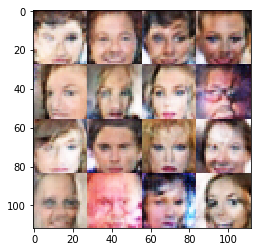

Generator Loss: 0.477 || Discriminator Loss: 1.354
Generator Loss: 0.358 || Discriminator Loss: 1.437
Generator Loss: 0.426 || Discriminator Loss: 1.391
Generator Loss: 0.399 || Discriminator Loss: 1.446
Generator Loss: 0.435 || Discriminator Loss: 1.470
Generator Loss: 0.429 || Discriminator Loss: 1.439
Generator Loss: 0.453 || Discriminator Loss: 1.457
Generator Loss: 0.509 || Discriminator Loss: 1.361
Generator Loss: 0.478 || Discriminator Loss: 1.363
Generator Loss: 0.447 || Discriminator Loss: 1.312


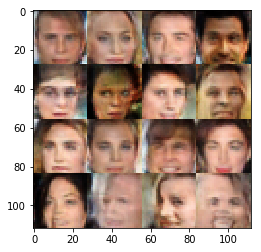

Generator Loss: 0.389 || Discriminator Loss: 1.413
Generator Loss: 0.441 || Discriminator Loss: 1.387
Generator Loss: 0.445 || Discriminator Loss: 1.353
Generator Loss: 0.516 || Discriminator Loss: 1.347
Generator Loss: 0.453 || Discriminator Loss: 1.412
Generator Loss: 0.487 || Discriminator Loss: 1.432
Generator Loss: 0.456 || Discriminator Loss: 1.400
Generator Loss: 0.454 || Discriminator Loss: 1.315
Generator Loss: 0.497 || Discriminator Loss: 1.406
Generator Loss: 0.495 || Discriminator Loss: 1.348


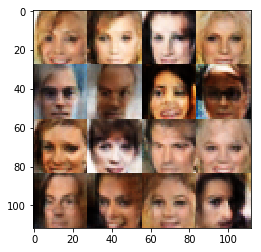

Generator Loss: 0.519 || Discriminator Loss: 1.358
Generator Loss: 0.485 || Discriminator Loss: 1.416
Generator Loss: 0.403 || Discriminator Loss: 1.328
Generator Loss: 0.468 || Discriminator Loss: 1.332
Generator Loss: 0.551 || Discriminator Loss: 1.348
Generator Loss: 0.434 || Discriminator Loss: 1.433
Generator Loss: 0.434 || Discriminator Loss: 1.384
Generator Loss: 0.383 || Discriminator Loss: 1.448
Generator Loss: 0.426 || Discriminator Loss: 1.386
Generator Loss: 0.393 || Discriminator Loss: 1.391


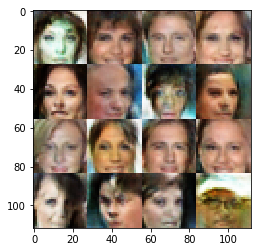

Generator Loss: 0.449 || Discriminator Loss: 1.366
Generator Loss: 0.429 || Discriminator Loss: 1.399
Generator Loss: 0.391 || Discriminator Loss: 1.435
Generator Loss: 0.566 || Discriminator Loss: 1.396
Generator Loss: 0.447 || Discriminator Loss: 1.320
Generator Loss: 0.490 || Discriminator Loss: 1.397
Generator Loss: 0.499 || Discriminator Loss: 1.394
Generator Loss: 0.450 || Discriminator Loss: 1.408
Generator Loss: 0.472 || Discriminator Loss: 1.360
Generator Loss: 0.508 || Discriminator Loss: 1.354


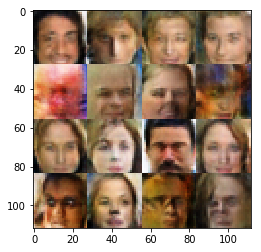

Generator Loss: 0.421 || Discriminator Loss: 1.426
Generator Loss: 0.478 || Discriminator Loss: 1.366
Generator Loss: 0.526 || Discriminator Loss: 1.318
Generator Loss: 0.378 || Discriminator Loss: 1.417
Generator Loss: 0.396 || Discriminator Loss: 1.402
Generator Loss: 0.375 || Discriminator Loss: 1.357
Generator Loss: 0.389 || Discriminator Loss: 1.406
Generator Loss: 0.512 || Discriminator Loss: 1.382
Generator Loss: 0.378 || Discriminator Loss: 1.466
Generator Loss: 0.414 || Discriminator Loss: 1.377


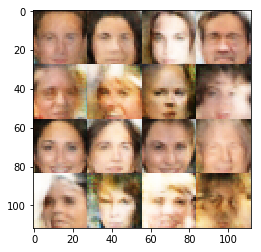

Generator Loss: 0.493 || Discriminator Loss: 1.366
Generator Loss: 0.430 || Discriminator Loss: 1.456
Generator Loss: 0.577 || Discriminator Loss: 1.422
Generator Loss: 0.514 || Discriminator Loss: 1.383
Generator Loss: 0.437 || Discriminator Loss: 1.391
Generator Loss: 0.477 || Discriminator Loss: 1.337
Generator Loss: 0.466 || Discriminator Loss: 1.402
Generator Loss: 0.476 || Discriminator Loss: 1.362
Generator Loss: 0.464 || Discriminator Loss: 1.349
Generator Loss: 0.514 || Discriminator Loss: 1.382


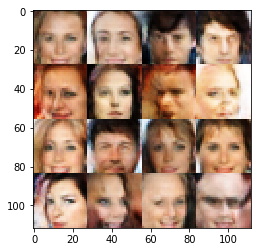

Generator Loss: 0.473 || Discriminator Loss: 1.475
Generator Loss: 0.449 || Discriminator Loss: 1.416
Generator Loss: 0.424 || Discriminator Loss: 1.464
Generator Loss: 0.438 || Discriminator Loss: 1.431
Generator Loss: 0.504 || Discriminator Loss: 1.376
Generator Loss: 0.467 || Discriminator Loss: 1.437
Generator Loss: 0.478 || Discriminator Loss: 1.342
Generator Loss: 0.470 || Discriminator Loss: 1.402
Generator Loss: 0.507 || Discriminator Loss: 1.381
Generator Loss: 0.501 || Discriminator Loss: 1.368


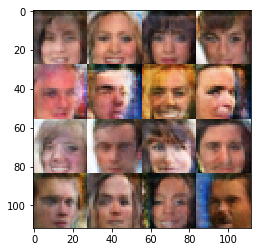

Generator Loss: 0.461 || Discriminator Loss: 1.415
Generator Loss: 0.503 || Discriminator Loss: 1.370
Generator Loss: 0.476 || Discriminator Loss: 1.360
Generator Loss: 0.494 || Discriminator Loss: 1.368
Generator Loss: 0.518 || Discriminator Loss: 1.357
Generator Loss: 0.540 || Discriminator Loss: 1.404
Generator Loss: 0.484 || Discriminator Loss: 1.409
Generator Loss: 0.494 || Discriminator Loss: 1.348
Generator Loss: 0.445 || Discriminator Loss: 1.427
Generator Loss: 0.534 || Discriminator Loss: 1.350


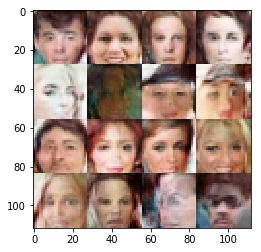

Generator Loss: 0.487 || Discriminator Loss: 1.371
Generator Loss: 0.439 || Discriminator Loss: 1.373
Generator Loss: 0.446 || Discriminator Loss: 1.390
Generator Loss: 0.560 || Discriminator Loss: 1.266
Generator Loss: 0.471 || Discriminator Loss: 1.360
Generator Loss: 0.523 || Discriminator Loss: 1.407
Generator Loss: 0.445 || Discriminator Loss: 1.452
Generator Loss: 0.464 || Discriminator Loss: 1.381
Generator Loss: 0.495 || Discriminator Loss: 1.377
Generator Loss: 0.419 || Discriminator Loss: 1.419


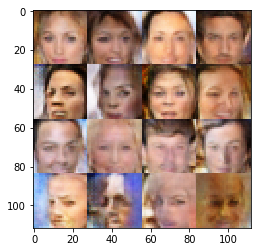

Generator Loss: 0.550 || Discriminator Loss: 1.387
Generator Loss: 0.440 || Discriminator Loss: 1.355
Generator Loss: 0.507 || Discriminator Loss: 1.366
Generator Loss: 0.421 || Discriminator Loss: 1.365
Generator Loss: 0.456 || Discriminator Loss: 1.389
Generator Loss: 0.379 || Discriminator Loss: 1.445
Generator Loss: 0.463 || Discriminator Loss: 1.401
Generator Loss: 0.495 || Discriminator Loss: 1.357
Generator Loss: 0.476 || Discriminator Loss: 1.333
Generator Loss: 0.457 || Discriminator Loss: 1.354


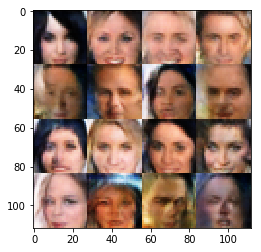

Generator Loss: 0.464 || Discriminator Loss: 1.357
Generator Loss: 0.357 || Discriminator Loss: 1.441
Generator Loss: 0.527 || Discriminator Loss: 1.320
Generator Loss: 0.342 || Discriminator Loss: 1.368
Generator Loss: 0.561 || Discriminator Loss: 1.388
Generator Loss: 0.482 || Discriminator Loss: 1.410
Generator Loss: 0.544 || Discriminator Loss: 1.289
Generator Loss: 0.418 || Discriminator Loss: 1.413
Generator Loss: 0.328 || Discriminator Loss: 1.363
Generator Loss: 0.446 || Discriminator Loss: 1.419


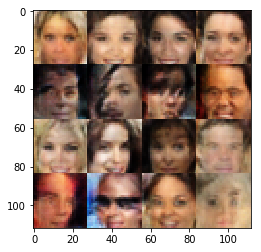

Generator Loss: 0.447 || Discriminator Loss: 1.403
Generator Loss: 0.438 || Discriminator Loss: 1.385
Generator Loss: 0.451 || Discriminator Loss: 1.390
Generator Loss: 0.469 || Discriminator Loss: 1.381
Generator Loss: 0.463 || Discriminator Loss: 1.397
Generator Loss: 0.466 || Discriminator Loss: 1.377
Generator Loss: 0.391 || Discriminator Loss: 1.317
Generator Loss: 0.460 || Discriminator Loss: 1.451
Generator Loss: 0.398 || Discriminator Loss: 1.367
Generator Loss: 0.446 || Discriminator Loss: 1.369


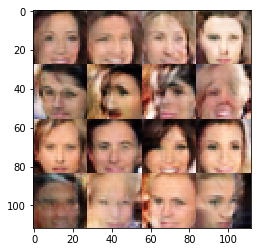

Generator Loss: 0.515 || Discriminator Loss: 1.327
Generator Loss: 0.450 || Discriminator Loss: 1.387
Generator Loss: 0.487 || Discriminator Loss: 1.405
Generator Loss: 0.400 || Discriminator Loss: 1.431
Generator Loss: 0.398 || Discriminator Loss: 1.429
Generator Loss: 0.493 || Discriminator Loss: 1.420
Generator Loss: 0.544 || Discriminator Loss: 1.378
Generator Loss: 0.476 || Discriminator Loss: 1.397
Generator Loss: 0.405 || Discriminator Loss: 1.394
Generator Loss: 0.452 || Discriminator Loss: 1.319


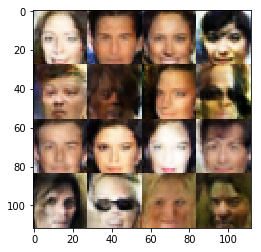

Generator Loss: 0.528 || Discriminator Loss: 1.371
Generator Loss: 0.442 || Discriminator Loss: 1.411
Generator Loss: 0.578 || Discriminator Loss: 1.343
Generator Loss: 0.498 || Discriminator Loss: 1.355
Generator Loss: 0.508 || Discriminator Loss: 1.372
Generator Loss: 0.438 || Discriminator Loss: 1.323
Generator Loss: 0.385 || Discriminator Loss: 1.414
Generator Loss: 0.418 || Discriminator Loss: 1.412
Generator Loss: 0.425 || Discriminator Loss: 1.423
Generator Loss: 0.520 || Discriminator Loss: 1.361


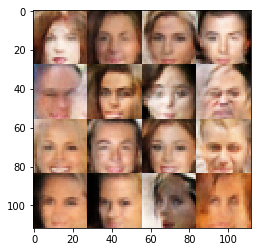

Generator Loss: 0.480 || Discriminator Loss: 1.329
Generator Loss: 0.410 || Discriminator Loss: 1.366
Generator Loss: 0.447 || Discriminator Loss: 1.369
Generator Loss: 0.479 || Discriminator Loss: 1.383
Generator Loss: 0.433 || Discriminator Loss: 1.407
Generator Loss: 0.506 || Discriminator Loss: 1.350
Generator Loss: 0.551 || Discriminator Loss: 1.353
Generator Loss: 0.411 || Discriminator Loss: 1.416
Generator Loss: 0.459 || Discriminator Loss: 1.414
Generator Loss: 0.409 || Discriminator Loss: 1.394


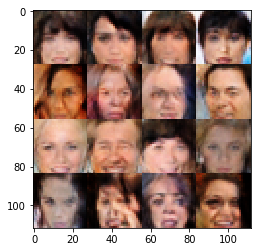

Generator Loss: 0.463 || Discriminator Loss: 1.406
Generator Loss: 0.489 || Discriminator Loss: 1.344
Generator Loss: 0.457 || Discriminator Loss: 1.368
Generator Loss: 0.422 || Discriminator Loss: 1.393
Generator Loss: 0.418 || Discriminator Loss: 1.432
Generator Loss: 0.487 || Discriminator Loss: 1.363
Generator Loss: 0.456 || Discriminator Loss: 1.402
Generator Loss: 0.472 || Discriminator Loss: 1.330
Generator Loss: 0.409 || Discriminator Loss: 1.415
Generator Loss: 0.421 || Discriminator Loss: 1.364


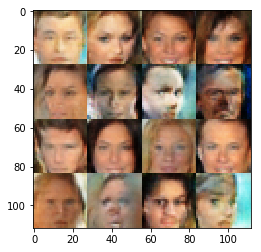

Generator Loss: 0.540 || Discriminator Loss: 1.289
Generator Loss: 0.408 || Discriminator Loss: 1.422
Generator Loss: 0.452 || Discriminator Loss: 1.341
Generator Loss: 0.386 || Discriminator Loss: 1.456
Generator Loss: 0.416 || Discriminator Loss: 1.356
Generator Loss: 0.423 || Discriminator Loss: 1.397
Generator Loss: 0.449 || Discriminator Loss: 1.351
Generator Loss: 0.433 || Discriminator Loss: 1.429
Generator Loss: 0.412 || Discriminator Loss: 1.409
Generator Loss: 0.456 || Discriminator Loss: 1.371


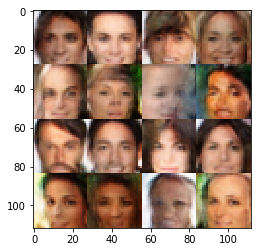

Generator Loss: 0.459 || Discriminator Loss: 1.366
Generator Loss: 0.458 || Discriminator Loss: 1.401
Generator Loss: 0.497 || Discriminator Loss: 1.318
Generator Loss: 0.485 || Discriminator Loss: 1.392
Generator Loss: 0.533 || Discriminator Loss: 1.357
Generator Loss: 0.410 || Discriminator Loss: 1.407
Generator Loss: 0.494 || Discriminator Loss: 1.379
Generator Loss: 0.412 || Discriminator Loss: 1.387
Generator Loss: 0.521 || Discriminator Loss: 1.436
Generator Loss: 0.421 || Discriminator Loss: 1.359


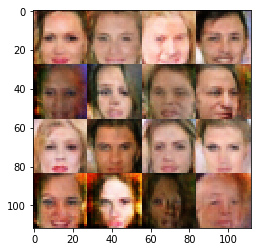

Generator Loss: 0.465 || Discriminator Loss: 1.450
Generator Loss: 0.516 || Discriminator Loss: 1.370
Generator Loss: 0.485 || Discriminator Loss: 1.353
Generator Loss: 0.330 || Discriminator Loss: 1.473
Generator Loss: 0.441 || Discriminator Loss: 1.371
Generator Loss: 0.450 || Discriminator Loss: 1.392
Generator Loss: 0.498 || Discriminator Loss: 1.400
Generator Loss: 0.342 || Discriminator Loss: 1.411
Generator Loss: 0.401 || Discriminator Loss: 1.375
Generator Loss: 0.444 || Discriminator Loss: 1.394


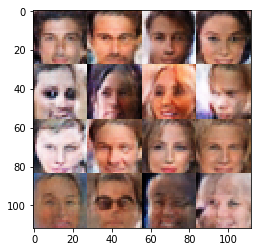

Generator Loss: 0.513 || Discriminator Loss: 1.391
Generator Loss: 0.453 || Discriminator Loss: 1.346
Generator Loss: 0.399 || Discriminator Loss: 1.394
Generator Loss: 0.412 || Discriminator Loss: 1.379
Generator Loss: 0.428 || Discriminator Loss: 1.387
Generator Loss: 0.488 || Discriminator Loss: 1.355
Generator Loss: 0.510 || Discriminator Loss: 1.403
Generator Loss: 0.437 || Discriminator Loss: 1.389
Generator Loss: 0.400 || Discriminator Loss: 1.343
Generator Loss: 0.340 || Discriminator Loss: 1.496


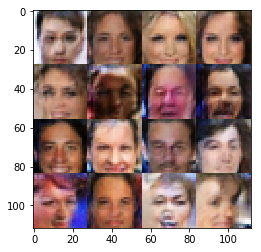

Generator Loss: 0.542 || Discriminator Loss: 1.351
Generator Loss: 0.520 || Discriminator Loss: 1.356
Generator Loss: 0.423 || Discriminator Loss: 1.383
Generator Loss: 0.518 || Discriminator Loss: 1.342
Generator Loss: 0.493 || Discriminator Loss: 1.334
Generator Loss: 0.446 || Discriminator Loss: 1.440
Generator Loss: 0.475 || Discriminator Loss: 1.359
Generator Loss: 0.542 || Discriminator Loss: 1.374
Generator Loss: 0.430 || Discriminator Loss: 1.317
Generator Loss: 0.471 || Discriminator Loss: 1.407


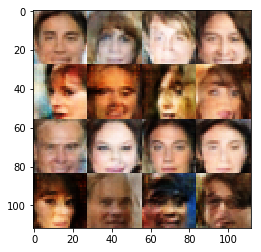

Generator Loss: 0.459 || Discriminator Loss: 1.358
Generator Loss: 0.514 || Discriminator Loss: 1.357
Generator Loss: 0.475 || Discriminator Loss: 1.445
Generator Loss: 0.502 || Discriminator Loss: 1.417
Generator Loss: 0.451 || Discriminator Loss: 1.379
Generator Loss: 0.453 || Discriminator Loss: 1.404
Generator Loss: 0.428 || Discriminator Loss: 1.356
Generator Loss: 0.508 || Discriminator Loss: 1.359
Generator Loss: 0.496 || Discriminator Loss: 1.385
Generator Loss: 0.488 || Discriminator Loss: 1.359


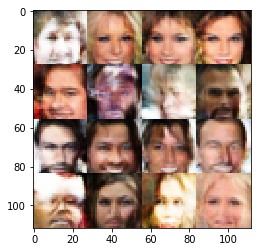

Generator Loss: 0.475 || Discriminator Loss: 1.403
Generator Loss: 0.496 || Discriminator Loss: 1.412
Generator Loss: 0.507 || Discriminator Loss: 1.371
Generator Loss: 0.452 || Discriminator Loss: 1.373
Generator Loss: 0.492 || Discriminator Loss: 1.361
Generator Loss: 0.429 || Discriminator Loss: 1.440
Generator Loss: 0.440 || Discriminator Loss: 1.394
Generator Loss: 0.412 || Discriminator Loss: 1.389
Generator Loss: 0.459 || Discriminator Loss: 1.334
Generator Loss: 0.487 || Discriminator Loss: 1.385


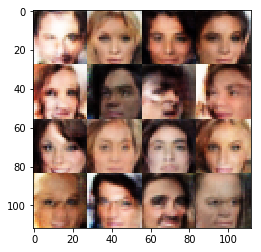

Generator Loss: 0.407 || Discriminator Loss: 1.377
Generator Loss: 0.516 || Discriminator Loss: 1.389
Generator Loss: 0.572 || Discriminator Loss: 1.364
Generator Loss: 0.446 || Discriminator Loss: 1.336
Generator Loss: 0.536 || Discriminator Loss: 1.373
Generator Loss: 0.403 || Discriminator Loss: 1.410
Generator Loss: 0.464 || Discriminator Loss: 1.339
Generator Loss: 0.457 || Discriminator Loss: 1.395
Generator Loss: 0.452 || Discriminator Loss: 1.438
Generator Loss: 0.454 || Discriminator Loss: 1.401


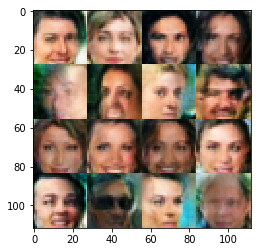

Generator Loss: 0.455 || Discriminator Loss: 1.420
Generator Loss: 0.377 || Discriminator Loss: 1.407
Generator Loss: 0.487 || Discriminator Loss: 1.302
Generator Loss: 0.564 || Discriminator Loss: 1.341
Generator Loss: 0.556 || Discriminator Loss: 1.352
Generator Loss: 0.421 || Discriminator Loss: 1.385
Generator Loss: 0.484 || Discriminator Loss: 1.357
Generator Loss: 0.439 || Discriminator Loss: 1.398
Generator Loss: 0.423 || Discriminator Loss: 1.479
Generator Loss: 0.448 || Discriminator Loss: 1.340


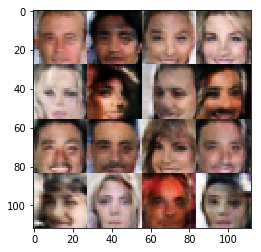

Generator Loss: 0.416 || Discriminator Loss: 1.395
Generator Loss: 0.514 || Discriminator Loss: 1.362
Generator Loss: 0.440 || Discriminator Loss: 1.392
Generator Loss: 0.433 || Discriminator Loss: 1.380
Generator Loss: 0.460 || Discriminator Loss: 1.390
Generator Loss: 0.470 || Discriminator Loss: 1.376
Generator Loss: 0.428 || Discriminator Loss: 1.401
Generator Loss: 0.518 || Discriminator Loss: 1.356
Generator Loss: 0.475 || Discriminator Loss: 1.367
Generator Loss: 0.467 || Discriminator Loss: 1.362


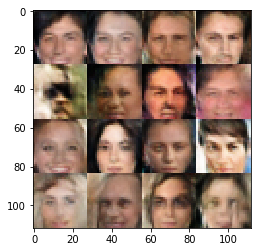

Generator Loss: 0.456 || Discriminator Loss: 1.332
Generator Loss: 0.432 || Discriminator Loss: 1.372
Generator Loss: 0.423 || Discriminator Loss: 1.472
Generator Loss: 0.497 || Discriminator Loss: 1.290
Generator Loss: 0.525 || Discriminator Loss: 1.328
Generator Loss: 0.453 || Discriminator Loss: 1.412
Generator Loss: 0.421 || Discriminator Loss: 1.382
Generator Loss: 0.547 || Discriminator Loss: 1.346
Generator Loss: 0.468 || Discriminator Loss: 1.367
Generator Loss: 0.447 || Discriminator Loss: 1.409


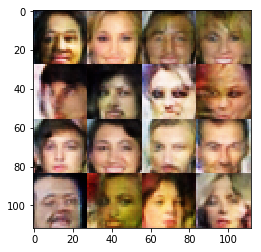

Generator Loss: 0.427 || Discriminator Loss: 1.337
Generator Loss: 0.486 || Discriminator Loss: 1.384
Generator Loss: 0.451 || Discriminator Loss: 1.407
Generator Loss: 0.491 || Discriminator Loss: 1.343
Generator Loss: 0.391 || Discriminator Loss: 1.381
Generator Loss: 0.432 || Discriminator Loss: 1.407
Generator Loss: 0.475 || Discriminator Loss: 1.398
Generator Loss: 0.389 || Discriminator Loss: 1.382
Generator Loss: 0.509 || Discriminator Loss: 1.375
Generator Loss: 0.436 || Discriminator Loss: 1.346


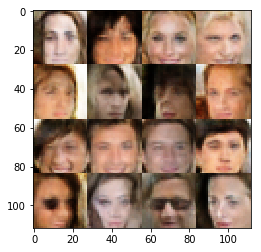

Generator Loss: 0.482 || Discriminator Loss: 1.395
Generator Loss: 0.419 || Discriminator Loss: 1.391
Generator Loss: 0.448 || Discriminator Loss: 1.390
Generator Loss: 0.481 || Discriminator Loss: 1.302
Generator Loss: 0.537 || Discriminator Loss: 1.326
Generator Loss: 0.479 || Discriminator Loss: 1.320
Generator Loss: 0.519 || Discriminator Loss: 1.361
Generator Loss: 0.502 || Discriminator Loss: 1.378
Generator Loss: 0.500 || Discriminator Loss: 1.375
Generator Loss: 0.479 || Discriminator Loss: 1.428


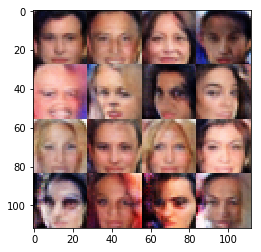

Generator Loss: 0.441 || Discriminator Loss: 1.429
Generator Loss: 0.455 || Discriminator Loss: 1.380
Generator Loss: 0.438 || Discriminator Loss: 1.411
Generator Loss: 0.461 || Discriminator Loss: 1.356
Generator Loss: 0.487 || Discriminator Loss: 1.319
Generator Loss: 0.498 || Discriminator Loss: 1.370
Generator Loss: 0.478 || Discriminator Loss: 1.378
Generator Loss: 0.471 || Discriminator Loss: 1.374
Generator Loss: 0.473 || Discriminator Loss: 1.349
Generator Loss: 0.445 || Discriminator Loss: 1.404


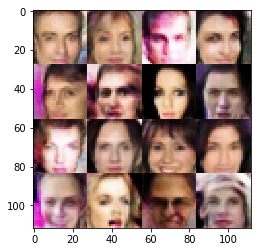

Generator Loss: 0.417 || Discriminator Loss: 1.381
Generator Loss: 0.437 || Discriminator Loss: 1.372
Generator Loss: 0.514 || Discriminator Loss: 1.361
Generator Loss: 0.450 || Discriminator Loss: 1.363
Generator Loss: 0.470 || Discriminator Loss: 1.330
Generator Loss: 0.485 || Discriminator Loss: 1.413
Generator Loss: 0.535 || Discriminator Loss: 1.397
Generator Loss: 0.474 || Discriminator Loss: 1.380
Generator Loss: 0.507 || Discriminator Loss: 1.364
Generator Loss: 0.419 || Discriminator Loss: 1.365


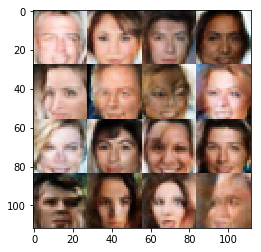

Generator Loss: 0.420 || Discriminator Loss: 1.422
Generator Loss: 0.454 || Discriminator Loss: 1.323
Generator Loss: 0.456 || Discriminator Loss: 1.371
Generator Loss: 0.450 || Discriminator Loss: 1.406
Generator Loss: 0.429 || Discriminator Loss: 1.379
Generator Loss: 0.513 || Discriminator Loss: 1.327
Generator Loss: 0.479 || Discriminator Loss: 1.391
Generator Loss: 0.520 || Discriminator Loss: 1.351
Generator Loss: 0.496 || Discriminator Loss: 1.410
Generator Loss: 0.465 || Discriminator Loss: 1.409


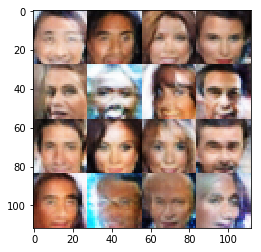

Generator Loss: 0.502 || Discriminator Loss: 1.351
Generator Loss: 0.451 || Discriminator Loss: 1.354
Generator Loss: 0.496 || Discriminator Loss: 1.364
Generator Loss: 0.428 || Discriminator Loss: 1.304
Generator Loss: 0.442 || Discriminator Loss: 1.367
Generator Loss: 0.565 || Discriminator Loss: 1.365
Generator Loss: 0.501 || Discriminator Loss: 1.335
Generator Loss: 0.483 || Discriminator Loss: 1.408
Generator Loss: 0.402 || Discriminator Loss: 1.388
Generator Loss: 0.417 || Discriminator Loss: 1.362


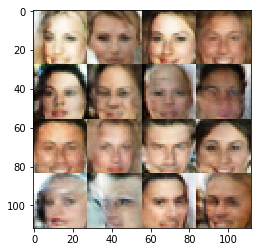

Generator Loss: 0.507 || Discriminator Loss: 1.414
Generator Loss: 0.487 || Discriminator Loss: 1.399
Generator Loss: 0.406 || Discriminator Loss: 1.360
Generator Loss: 0.449 || Discriminator Loss: 1.364
Generator Loss: 0.491 || Discriminator Loss: 1.354
Generator Loss: 0.490 || Discriminator Loss: 1.418
Generator Loss: 0.509 || Discriminator Loss: 1.344
Generator Loss: 0.451 || Discriminator Loss: 1.406
Generator Loss: 0.492 || Discriminator Loss: 1.391
Generator Loss: 0.433 || Discriminator Loss: 1.364


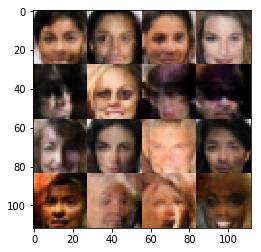

Generator Loss: 0.417 || Discriminator Loss: 1.337
Generator Loss: 0.489 || Discriminator Loss: 1.363
Generator Loss: 0.473 || Discriminator Loss: 1.309
Generator Loss: 0.480 || Discriminator Loss: 1.306
Generator Loss: 0.467 || Discriminator Loss: 1.335
Generator Loss: 0.500 || Discriminator Loss: 1.403
Generator Loss: 0.394 || Discriminator Loss: 1.378
Generator Loss: 0.449 || Discriminator Loss: 1.394
Generator Loss: 0.493 || Discriminator Loss: 1.407
Generator Loss: 0.503 || Discriminator Loss: 1.335


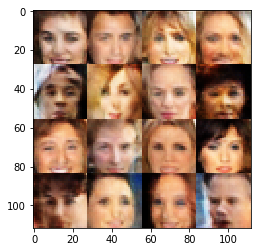

Generator Loss: 0.465 || Discriminator Loss: 1.387
Generator Loss: 0.415 || Discriminator Loss: 1.428
Generator Loss: 0.459 || Discriminator Loss: 1.338
Generator Loss: 0.476 || Discriminator Loss: 1.400
Generator Loss: 0.464 || Discriminator Loss: 1.359
Generator Loss: 0.454 || Discriminator Loss: 1.355
Generator Loss: 0.499 || Discriminator Loss: 1.388
Generator Loss: 0.447 || Discriminator Loss: 1.348
Generator Loss: 0.510 || Discriminator Loss: 1.385
Generator Loss: 0.468 || Discriminator Loss: 1.360


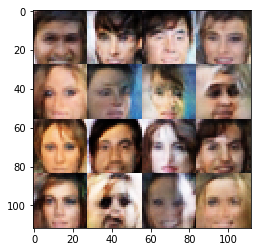

Generator Loss: 0.499 || Discriminator Loss: 1.400
Generator Loss: 0.509 || Discriminator Loss: 1.396
Generator Loss: 0.524 || Discriminator Loss: 1.375
Generator Loss: 0.490 || Discriminator Loss: 1.394
Generator Loss: 0.409 || Discriminator Loss: 1.382
Generator Loss: 0.393 || Discriminator Loss: 1.420
Generator Loss: 0.571 || Discriminator Loss: 1.412
Generator Loss: 0.447 || Discriminator Loss: 1.370
Generator Loss: 0.407 || Discriminator Loss: 1.405
Generator Loss: 0.485 || Discriminator Loss: 1.400


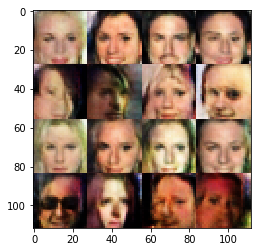

Generator Loss: 0.465 || Discriminator Loss: 1.371
Generator Loss: 0.450 || Discriminator Loss: 1.371
Generator Loss: 0.424 || Discriminator Loss: 1.390
Generator Loss: 0.499 || Discriminator Loss: 1.412
Generator Loss: 0.477 || Discriminator Loss: 1.360
Generator Loss: 0.448 || Discriminator Loss: 1.370
Generator Loss: 0.395 || Discriminator Loss: 1.436
Generator Loss: 0.503 || Discriminator Loss: 1.413
Generator Loss: 0.529 || Discriminator Loss: 1.381
Generator Loss: 0.352 || Discriminator Loss: 1.468


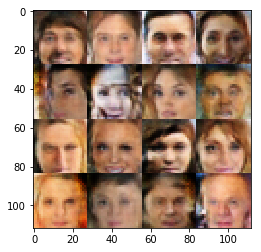

Generator Loss: 0.440 || Discriminator Loss: 1.379
Generator Loss: 0.403 || Discriminator Loss: 1.353
Generator Loss: 0.430 || Discriminator Loss: 1.437
Generator Loss: 0.419 || Discriminator Loss: 1.400
Generator Loss: 0.439 || Discriminator Loss: 1.424
Generator Loss: 0.453 || Discriminator Loss: 1.335
Generator Loss: 0.523 || Discriminator Loss: 1.399
Generator Loss: 0.382 || Discriminator Loss: 1.417
Generator Loss: 0.479 || Discriminator Loss: 1.324
Generator Loss: 0.434 || Discriminator Loss: 1.375


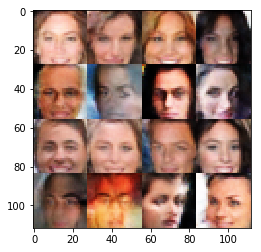

Generator Loss: 0.442 || Discriminator Loss: 1.363
Generator Loss: 0.380 || Discriminator Loss: 1.424
Generator Loss: 0.526 || Discriminator Loss: 1.379
Generator Loss: 0.430 || Discriminator Loss: 1.427
Generator Loss: 0.514 || Discriminator Loss: 1.378
Generator Loss: 0.434 || Discriminator Loss: 1.357
Generator Loss: 0.496 || Discriminator Loss: 1.352
Generator Loss: 0.440 || Discriminator Loss: 1.451
Generator Loss: 0.487 || Discriminator Loss: 1.356
Generator Loss: 0.477 || Discriminator Loss: 1.333


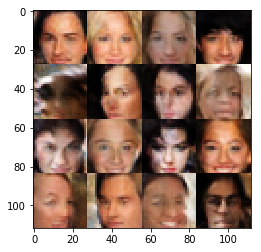

Generator Loss: 0.417 || Discriminator Loss: 1.401
Generator Loss: 0.506 || Discriminator Loss: 1.399
Generator Loss: 0.526 || Discriminator Loss: 1.343
Generator Loss: 0.442 || Discriminator Loss: 1.384
Generator Loss: 0.455 || Discriminator Loss: 1.390
Generator Loss: 0.487 || Discriminator Loss: 1.403
Generator Loss: 0.404 || Discriminator Loss: 1.409
Generator Loss: 0.505 || Discriminator Loss: 1.411
Generator Loss: 0.455 || Discriminator Loss: 1.377
Generator Loss: 0.421 || Discriminator Loss: 1.335


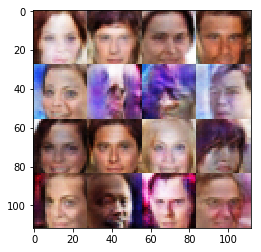

Generator Loss: 0.417 || Discriminator Loss: 1.418
Generator Loss: 0.471 || Discriminator Loss: 1.402
Generator Loss: 0.416 || Discriminator Loss: 1.393
Generator Loss: 0.492 || Discriminator Loss: 1.334
Generator Loss: 0.467 || Discriminator Loss: 1.371
Generator Loss: 0.496 || Discriminator Loss: 1.356
Generator Loss: 0.458 || Discriminator Loss: 1.366
Generator Loss: 0.470 || Discriminator Loss: 1.437
Generator Loss: 0.479 || Discriminator Loss: 1.332
Generator Loss: 0.503 || Discriminator Loss: 1.376


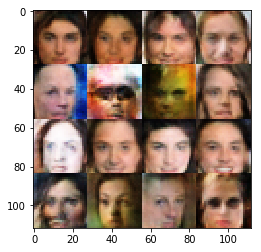

Generator Loss: 0.408 || Discriminator Loss: 1.372
Generator Loss: 0.528 || Discriminator Loss: 1.397
Generator Loss: 0.443 || Discriminator Loss: 1.376
Generator Loss: 0.455 || Discriminator Loss: 1.397
Generator Loss: 0.457 || Discriminator Loss: 1.311
Generator Loss: 0.491 || Discriminator Loss: 1.382
Generator Loss: 0.451 || Discriminator Loss: 1.384
Generator Loss: 0.515 || Discriminator Loss: 1.413
Generator Loss: 0.513 || Discriminator Loss: 1.405
Generator Loss: 0.516 || Discriminator Loss: 1.298


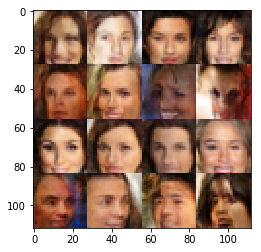

Generator Loss: 0.485 || Discriminator Loss: 1.367
Generator Loss: 0.534 || Discriminator Loss: 1.273
Generator Loss: 0.468 || Discriminator Loss: 1.380
Generator Loss: 0.464 || Discriminator Loss: 1.389
Generator Loss: 0.409 || Discriminator Loss: 1.409
Generator Loss: 0.465 || Discriminator Loss: 1.419
Generator Loss: 0.455 || Discriminator Loss: 1.425
Generator Loss: 0.499 || Discriminator Loss: 1.404
Generator Loss: 0.487 || Discriminator Loss: 1.415
Generator Loss: 0.432 || Discriminator Loss: 1.489


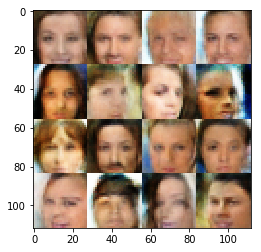

Generator Loss: 0.486 || Discriminator Loss: 1.351
Generator Loss: 0.509 || Discriminator Loss: 1.383
Generator Loss: 0.436 || Discriminator Loss: 1.425
Generator Loss: 0.447 || Discriminator Loss: 1.382
Generator Loss: 0.471 || Discriminator Loss: 1.378
Generator Loss: 0.398 || Discriminator Loss: 1.459
Generator Loss: 0.506 || Discriminator Loss: 1.386
Generator Loss: 0.480 || Discriminator Loss: 1.319
Generator Loss: 0.473 || Discriminator Loss: 1.346
Generator Loss: 0.474 || Discriminator Loss: 1.357


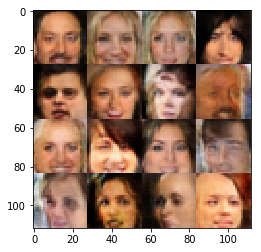

Generator Loss: 0.488 || Discriminator Loss: 1.377
Generator Loss: 0.516 || Discriminator Loss: 1.341
Generator Loss: 0.403 || Discriminator Loss: 1.505
Generator Loss: 0.563 || Discriminator Loss: 1.396
Generator Loss: 0.489 || Discriminator Loss: 1.323
Generator Loss: 0.474 || Discriminator Loss: 1.381
Generator Loss: 0.552 || Discriminator Loss: 1.367
Generator Loss: 0.443 || Discriminator Loss: 1.385
Generator Loss: 0.424 || Discriminator Loss: 1.353
Generator Loss: 0.464 || Discriminator Loss: 1.393


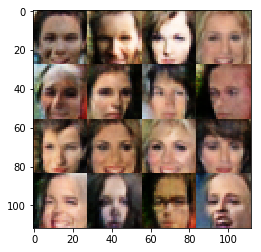

Generator Loss: 0.482 || Discriminator Loss: 1.384
Generator Loss: 0.506 || Discriminator Loss: 1.379
Generator Loss: 0.424 || Discriminator Loss: 1.354
Generator Loss: 0.512 || Discriminator Loss: 1.359
Generator Loss: 0.434 || Discriminator Loss: 1.394
Generator Loss: 0.522 || Discriminator Loss: 1.406
Generator Loss: 0.401 || Discriminator Loss: 1.409
Generator Loss: 0.493 || Discriminator Loss: 1.368
Generator Loss: 0.475 || Discriminator Loss: 1.362
Generator Loss: 0.492 || Discriminator Loss: 1.344


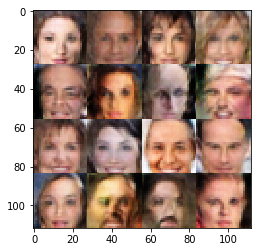

Generator Loss: 0.433 || Discriminator Loss: 1.439
Generator Loss: 0.520 || Discriminator Loss: 1.412
Generator Loss: 0.501 || Discriminator Loss: 1.342
Generator Loss: 0.524 || Discriminator Loss: 1.437
Generator Loss: 0.481 || Discriminator Loss: 1.319
Generator Loss: 0.410 || Discriminator Loss: 1.380
Generator Loss: 0.503 || Discriminator Loss: 1.344
Generator Loss: 0.494 || Discriminator Loss: 1.395
Generator Loss: 0.451 || Discriminator Loss: 1.398
Generator Loss: 0.479 || Discriminator Loss: 1.423


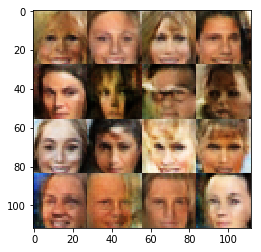

Generator Loss: 0.419 || Discriminator Loss: 1.397
Generator Loss: 0.465 || Discriminator Loss: 1.351
Generator Loss: 0.453 || Discriminator Loss: 1.394
Generator Loss: 0.470 || Discriminator Loss: 1.296
Generator Loss: 0.523 || Discriminator Loss: 1.318
Generator Loss: 0.537 || Discriminator Loss: 1.388
Generator Loss: 0.444 || Discriminator Loss: 1.380
Generator Loss: 0.447 || Discriminator Loss: 1.331
Generator Loss: 0.517 || Discriminator Loss: 1.377
Generator Loss: 0.551 || Discriminator Loss: 1.326


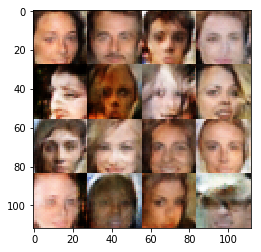

Generator Loss: 0.413 || Discriminator Loss: 1.464
Generator Loss: 0.598 || Discriminator Loss: 1.386
Generator Loss: 0.488 || Discriminator Loss: 1.344
Generator Loss: 0.485 || Discriminator Loss: 1.423
Generator Loss: 0.530 || Discriminator Loss: 1.383
Generator Loss: 0.390 || Discriminator Loss: 1.370
Generator Loss: 0.476 || Discriminator Loss: 1.367
Generator Loss: 0.451 || Discriminator Loss: 1.339
Generator Loss: 0.468 || Discriminator Loss: 1.379
Generator Loss: 0.414 || Discriminator Loss: 1.379


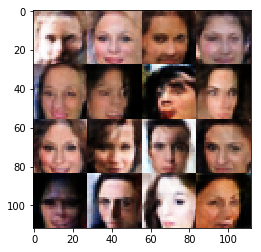

Generator Loss: 0.485 || Discriminator Loss: 1.381
Generator Loss: 0.509 || Discriminator Loss: 1.352
Generator Loss: 0.480 || Discriminator Loss: 1.409
Generator Loss: 0.481 || Discriminator Loss: 1.341
Generator Loss: 0.483 || Discriminator Loss: 1.381
Generator Loss: 0.506 || Discriminator Loss: 1.311
Generator Loss: 0.495 || Discriminator Loss: 1.353
Generator Loss: 0.440 || Discriminator Loss: 1.411
Generator Loss: 0.648 || Discriminator Loss: 1.325
Generator Loss: 0.583 || Discriminator Loss: 1.355


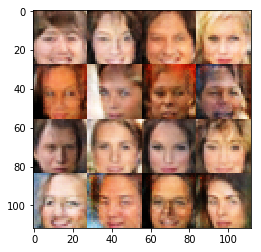

Generator Loss: 0.397 || Discriminator Loss: 1.379
Generator Loss: 0.461 || Discriminator Loss: 1.362
Generator Loss: 0.473 || Discriminator Loss: 1.367
Generator Loss: 0.473 || Discriminator Loss: 1.336
Generator Loss: 0.459 || Discriminator Loss: 1.412
Generator Loss: 0.460 || Discriminator Loss: 1.349
Generator Loss: 0.505 || Discriminator Loss: 1.364
Generator Loss: 0.482 || Discriminator Loss: 1.404
Generator Loss: 0.467 || Discriminator Loss: 1.336
Generator Loss: 0.482 || Discriminator Loss: 1.368


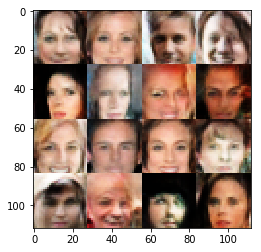

Generator Loss: 0.479 || Discriminator Loss: 1.361
Generator Loss: 0.436 || Discriminator Loss: 1.396
Generator Loss: 0.485 || Discriminator Loss: 1.354
Generator Loss: 0.558 || Discriminator Loss: 1.292
Generator Loss: 0.405 || Discriminator Loss: 1.381
Generator Loss: 0.477 || Discriminator Loss: 1.374
Generator Loss: 0.512 || Discriminator Loss: 1.454
Generator Loss: 0.450 || Discriminator Loss: 1.407
Generator Loss: 0.463 || Discriminator Loss: 1.392
Generator Loss: 0.410 || Discriminator Loss: 1.356


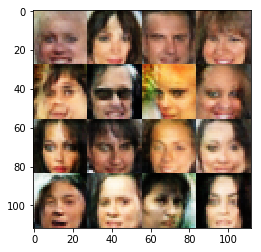

Generator Loss: 0.475 || Discriminator Loss: 1.376
Generator Loss: 0.451 || Discriminator Loss: 1.403
Generator Loss: 0.411 || Discriminator Loss: 1.384
Generator Loss: 0.454 || Discriminator Loss: 1.373
Generator Loss: 0.459 || Discriminator Loss: 1.390
Generator Loss: 0.483 || Discriminator Loss: 1.370
Generator Loss: 0.438 || Discriminator Loss: 1.330
Generator Loss: 0.508 || Discriminator Loss: 1.330
Generator Loss: 0.535 || Discriminator Loss: 1.384
Generator Loss: 0.478 || Discriminator Loss: 1.380


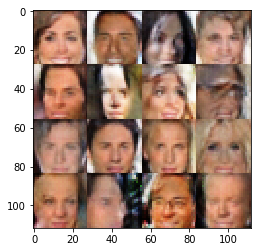

Generator Loss: 0.451 || Discriminator Loss: 1.356
Generator Loss: 0.491 || Discriminator Loss: 1.373
Generator Loss: 0.509 || Discriminator Loss: 1.376
Generator Loss: 0.426 || Discriminator Loss: 1.365
Generator Loss: 0.426 || Discriminator Loss: 1.374
Generator Loss: 0.428 || Discriminator Loss: 1.425
Generator Loss: 0.582 || Discriminator Loss: 1.314
Generator Loss: 0.468 || Discriminator Loss: 1.362
Generator Loss: 0.467 || Discriminator Loss: 1.411
Generator Loss: 0.461 || Discriminator Loss: 1.345


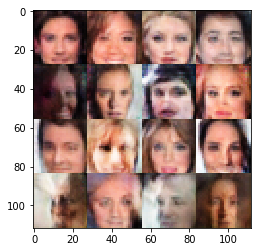

Generator Loss: 0.483 || Discriminator Loss: 1.372
Generator Loss: 0.416 || Discriminator Loss: 1.389
Generator Loss: 0.484 || Discriminator Loss: 1.328
Generator Loss: 0.477 || Discriminator Loss: 1.403
Generator Loss: 0.484 || Discriminator Loss: 1.341
Generator Loss: 0.489 || Discriminator Loss: 1.383
Generator Loss: 0.463 || Discriminator Loss: 1.365
Generator Loss: 0.465 || Discriminator Loss: 1.408
Generator Loss: 0.491 || Discriminator Loss: 1.350
Generator Loss: 0.468 || Discriminator Loss: 1.354


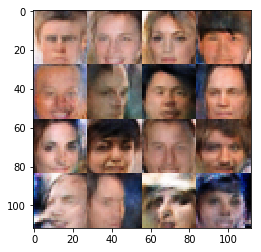

Generator Loss: 0.516 || Discriminator Loss: 1.281
Generator Loss: 0.442 || Discriminator Loss: 1.388
Generator Loss: 0.527 || Discriminator Loss: 1.374
Generator Loss: 0.444 || Discriminator Loss: 1.376
Generator Loss: 0.468 || Discriminator Loss: 1.321
Generator Loss: 0.440 || Discriminator Loss: 1.447
Generator Loss: 0.503 || Discriminator Loss: 1.372
Generator Loss: 0.468 || Discriminator Loss: 1.370
Generator Loss: 0.443 || Discriminator Loss: 1.297
Generator Loss: 0.410 || Discriminator Loss: 1.370


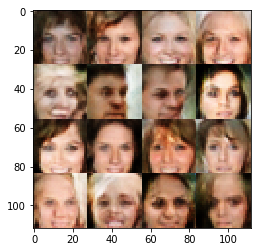

Generator Loss: 0.446 || Discriminator Loss: 1.352
Generator Loss: 0.508 || Discriminator Loss: 1.343
Generator Loss: 0.490 || Discriminator Loss: 1.330
Generator Loss: 0.430 || Discriminator Loss: 1.382
Generator Loss: 0.499 || Discriminator Loss: 1.374
Generator Loss: 0.474 || Discriminator Loss: 1.383
Generator Loss: 0.496 || Discriminator Loss: 1.332
Generator Loss: 0.513 || Discriminator Loss: 1.404
Generator Loss: 0.514 || Discriminator Loss: 1.351
Generator Loss: 0.520 || Discriminator Loss: 1.370


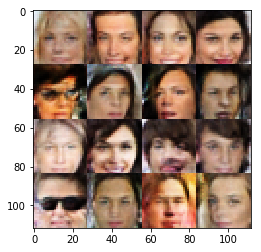

Generator Loss: 0.504 || Discriminator Loss: 1.362
Generator Loss: 0.506 || Discriminator Loss: 1.347
Generator Loss: 0.504 || Discriminator Loss: 1.383
Generator Loss: 0.438 || Discriminator Loss: 1.369
Generator Loss: 0.448 || Discriminator Loss: 1.348
Generator Loss: 0.413 || Discriminator Loss: 1.350
Generator Loss: 0.492 || Discriminator Loss: 1.370
Generator Loss: 0.458 || Discriminator Loss: 1.395
Generator Loss: 0.528 || Discriminator Loss: 1.355
Generator Loss: 0.424 || Discriminator Loss: 1.388


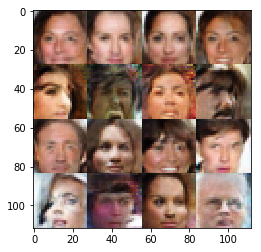

Generator Loss: 0.542 || Discriminator Loss: 1.345
Generator Loss: 0.428 || Discriminator Loss: 1.392
Generator Loss: 0.483 || Discriminator Loss: 1.336
Generator Loss: 0.480 || Discriminator Loss: 1.382
Generator Loss: 0.532 || Discriminator Loss: 1.361
Generator Loss: 0.423 || Discriminator Loss: 1.436
Generator Loss: 0.469 || Discriminator Loss: 1.340
Generator Loss: 0.498 || Discriminator Loss: 1.355
Generator Loss: 0.438 || Discriminator Loss: 1.395
Generator Loss: 0.457 || Discriminator Loss: 1.351


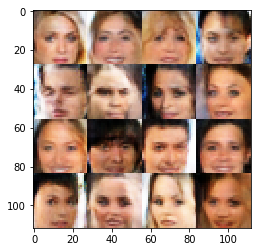

Generator Loss: 0.477 || Discriminator Loss: 1.350
Generator Loss: 0.445 || Discriminator Loss: 1.378
Generator Loss: 0.470 || Discriminator Loss: 1.363
Generator Loss: 0.478 || Discriminator Loss: 1.358
Generator Loss: 0.486 || Discriminator Loss: 1.356
Generator Loss: 0.457 || Discriminator Loss: 1.380
Generator Loss: 0.484 || Discriminator Loss: 1.383
Generator Loss: 0.465 || Discriminator Loss: 1.385
Generator Loss: 0.470 || Discriminator Loss: 1.391
Generator Loss: 0.465 || Discriminator Loss: 1.382


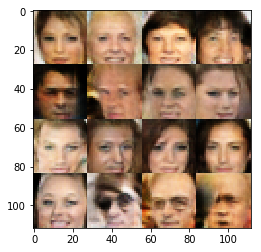

Generator Loss: 0.567 || Discriminator Loss: 1.370
Generator Loss: 0.462 || Discriminator Loss: 1.371
Generator Loss: 0.486 || Discriminator Loss: 1.350
Generator Loss: 0.462 || Discriminator Loss: 1.389
Generator Loss: 0.514 || Discriminator Loss: 1.382
Generator Loss: 0.460 || Discriminator Loss: 1.371
Generator Loss: 0.488 || Discriminator Loss: 1.382
Generator Loss: 0.503 || Discriminator Loss: 1.321
Generator Loss: 0.500 || Discriminator Loss: 1.401
Generator Loss: 0.522 || Discriminator Loss: 1.434


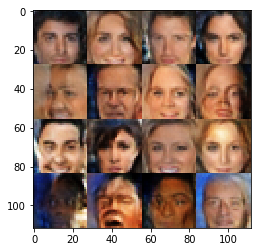

Generator Loss: 0.475 || Discriminator Loss: 1.429
Generator Loss: 0.511 || Discriminator Loss: 1.383
Generator Loss: 0.479 || Discriminator Loss: 1.394
Generator Loss: 0.520 || Discriminator Loss: 1.382
Generator Loss: 0.440 || Discriminator Loss: 1.352
Generator Loss: 0.479 || Discriminator Loss: 1.334
Generator Loss: 0.527 || Discriminator Loss: 1.383
Generator Loss: 0.410 || Discriminator Loss: 1.440
Generator Loss: 0.485 || Discriminator Loss: 1.345
Generator Loss: 0.399 || Discriminator Loss: 1.386


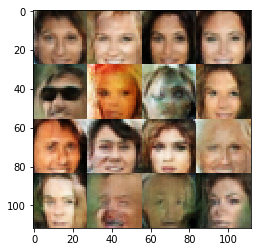

Generator Loss: 0.443 || Discriminator Loss: 1.373
Generator Loss: 0.459 || Discriminator Loss: 1.383
Generator Loss: 0.494 || Discriminator Loss: 1.357
Generator Loss: 0.491 || Discriminator Loss: 1.343
Generator Loss: 0.455 || Discriminator Loss: 1.337
Generator Loss: 0.399 || Discriminator Loss: 1.397
Generator Loss: 0.467 || Discriminator Loss: 1.382
Generator Loss: 0.429 || Discriminator Loss: 1.433
Generator Loss: 0.502 || Discriminator Loss: 1.351
Generator Loss: 0.464 || Discriminator Loss: 1.339


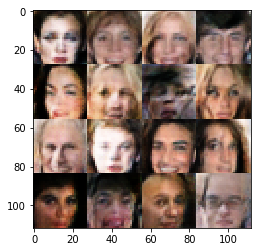

Generator Loss: 0.511 || Discriminator Loss: 1.377
Generator Loss: 0.454 || Discriminator Loss: 1.346
Generator Loss: 0.571 || Discriminator Loss: 1.346
Generator Loss: 0.497 || Discriminator Loss: 1.389
Generator Loss: 0.529 || Discriminator Loss: 1.347
Generator Loss: 0.506 || Discriminator Loss: 1.375


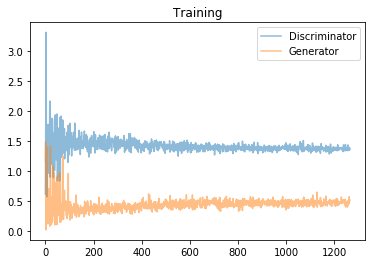

In [13]:
batch_size = 16
z_dim = 128
learning_rate = 0.0002
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.